In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from matplotlib.collections import LineCollection
import cmocean

import numpy as np
import scipy
from scipy import signal
from scipy import stats as stats
from scipy.stats import binned_statistic

import mne
import pickle
import pandas as pd

import statsmodels
from statsmodels.formula.api import ols, mixedlm
import statsmodels.api as sm

In [2]:
"""
This cell contains useful functions and variables to analyse the data and, plotting settings
"""



################################################
# Plot settings
plo = {}
plo['speed_color']   = '#1f77b4'
plo['density_color'] = '#ff7f03'
plo['cuesec_color']  = 'grey'


# Significance bar and text
def label_diff(i,j,text,X,Y):
    x = (X[i]+X[j])/2
    y = 1.005*max(Y[i], Y[j])
    dx = abs(X[i]-X[j])

    props = {'connectionstyle':'bar','arrowstyle':'-',\
                 'shrinkA':20,'shrinkB':20,'linewidth':2, 'color':'k'}
    ax.annotate(text, xy=(X[i]+0.2,y+0.03), zorder=1)
    ax.annotate('', xy=(X[i],y), xytext=(X[j],y), arrowprops=props)

    


################################################

def smooth_psd(p, sz=40, sigma=10):
    '''
    sz :  length of gaussFilter vector
    sigma = 10
    '''
    x = np.linspace(-sz / 2, sz / 2, sz);
    gaussFilter = np.exp(-x** 2 / (2 * sigma**2));
    gaussFilter = gaussFilter / sum (gaussFilter); # normalize
    pp = np.convolve(p, gaussFilter, 'same');
    return pp


    
def hilbert_transform(tmp_lfp_notch, fs, l_f_amp,h_f_amp):

    info = mne.create_info(ch_names=['lfp'], sfreq=fs, ch_types=['eeg'], verbose=False)
    raw = mne.io.RawArray([tmp_lfp_notch], info, verbose=False)

    raw_band = raw.copy()
    raw_band.filter(2, 8, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin', verbose=False)
    raw_hilb = raw_band.copy()
    hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
    raw_hilb.apply_hilbert(hilb_picks, verbose=False)
    raw_phase = raw_hilb.copy()
    raw_phase.apply_function(np.angle, hilb_picks)
    raw_phase = raw_phase.get_data()[0].real

    raw_band = raw.copy()
    raw_band.filter(l_f_amp,h_f_amp, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin', verbose=False)
    raw_hilb = raw_band.copy()
    hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
    raw_hilb.apply_hilbert(hilb_picks, verbose=False)
    raw_amp = raw_hilb.copy()
    raw_amp.apply_function(np.abs, hilb_picks)
    raw_amp = raw_amp.get_data()[0].real

    return raw_phase, raw_amp




def hilbert_transform_get_component(tmp_lfp_notch, fs, low_amp_freq,high_amp_freq, component):
    
    '''
    Transform signal and get either phase or amplitude component
    component: 'phase' or 'amplitude'
    '''

    info = mne.create_info(ch_names=['lfp'], sfreq=fs, ch_types=['eeg'])
    raw = mne.io.RawArray([tmp_lfp_notch], info)
    
    if component == 'phase':

        raw_band = raw.copy()
        raw_band.filter(low_amp_freq,high_amp_freq, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin', verbose=False)
        raw_hilb = raw_band.copy()
        hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
        raw_hilb.apply_hilbert(hilb_picks)
        raw_out = raw_hilb.copy()
        raw_out.apply_function(np.angle, hilb_picks)
        raw_out = raw_out.get_data()[0].real
        
    if component == 'amplitude':


        raw_band = raw.copy()
        raw_band.filter(low_amp_freq,high_amp_freq, l_trans_bandwidth=2., h_trans_bandwidth=2., fir_design='firwin', verbose=False)
        raw_hilb = raw_band.copy()
        hilb_picks = mne.pick_types(raw_band.info, meg=False, eeg=True)
        raw_hilb.apply_hilbert(hilb_picks)
        raw_out = raw_hilb.copy()
        raw_out.apply_function(np.abs, hilb_picks)
        raw_out = raw_out.get_data()[0].real

    return raw_out





def calculate_KB(bs):

    'PAD is the phase amp distribution'
    pad = bs[0]
    pad_2 = np.hstack((pad , pad))

    num_bins = pad_2.size
    n_pevents = float(np.sum(pad_2))
    ppp = -1 * np.sum((pad_2/n_pevents) * np.log((pad_2/n_pevents)))
    K_L = (np.log(num_bins) - ppp) / np.log(num_bins)

    return K_L


def get_ITPC(data):
    '''Inter trial phase coherence'''
    N = data.shape[0]
    itpc = np.abs( (1./N) *np.sum( np.exp( np.angle(data) * 1j ), axis=0 ) )
    return itpc

In [3]:
## Trial type related info
density = np.tile( np.repeat( np.arange(3), 3 ),3)
speed   = np.tile( np.arange(3), 9 )
dur     = np.tile( np.array([ 18.1, 13.5, 11]), 3).reshape(3,3).T
dd      = np.tile(np.array([50,100,150]),3).reshape(3,3)
K_i     = dd/dur
unii    = K_i[speed,density]
K_i_idx = (  np.tile(np.arange(3),3), np.repeat(np.arange(3),3)  ) 
ttl_info_dict = pickle.load( open( "ttl_info_dict.p", "rb" ) )

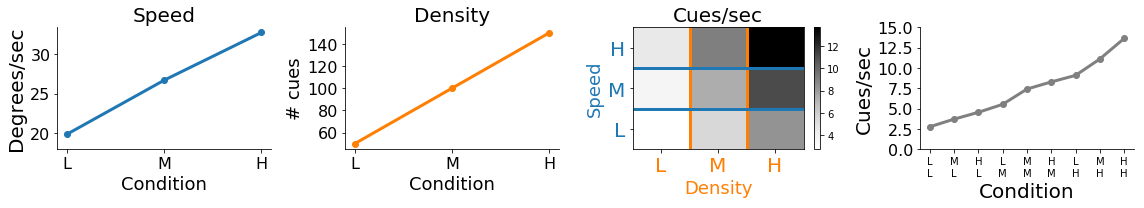

In [1000]:
lmh_labels = ['L','M','H']

fig , ax = plt.subplots(1,4)
fig.set_figheight(3)
fig.set_figwidth(16)
fig.set_facecolor('white')

plt.sca(ax[0])    
plt.plot(np.round(360/dur[:,0],1),'-o', color=plo['speed_color'],linewidth=3)
# plt.plot(dur[:,0][::-1],'-o', color=plo['speed_color'],linewidth=3)
plt.ylabel('Degrees/sec', fontsize=20)
plt.title('Speed', fontsize=20)
plt.ylim(18)

plt.sca(ax[1])
plt.plot(dd[0],'-o', color=plo['density_color'],linewidth=3)
plt.title('Density', fontsize=20)
plt.ylabel('# cues', fontsize=18)



for ii in range(2):
    ax[ii].spines['right'].set_visible(False)
    ax[ii].spines['top'].set_visible(False)
    plt.sca(ax[ii])
    plt.xticks(range(3),lmh_labels, fontsize=16)
    plt.yticks( fontsize=16)
    plt.xlabel('Condition', fontsize=18)

    
    
###### pcolor
plt.sca(ax[2])
plt.pcolor(K_i, cmap='Greys')
plt.colorbar()
plt.title('Cues/sec', fontsize=20)

plt.yticks(np.arange(3)+.5,lmh_labels, fontsize=20,color=plo['speed_color']  )
plt.xticks(np.arange(3)+.5,lmh_labels, fontsize=20,color=plo['density_color']  )

plt.ylabel('Speed', fontsize=18,  color=plo['speed_color'] )
plt.xlabel('Density', fontsize=18,  color=plo['density_color'])

plt.vlines([1,2],0,3,color=plo['density_color'], linewidth=3)
plt.hlines([1,2],0,3,color=plo['speed_color'], linewidth=3)

###### cues/sec line plot
plt.sca(ax[3])
plt.plot(np.sort(np.unique(unii)), '-o', color=plo['cuesec_color'], linewidth=3)
plt.xlabel('Condition', fontsize=20)
plt.ylabel('Cues/sec', fontsize=20)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)



cue_sec_xticks = []
for ii in range(len(K_i_idx[0])):
    cue_sec_xticks.append( str( ['L','M','H'][K_i_idx[0][ii]]  )+'\n'+str(  ['L','M','H'][K_i_idx[1][ii]]   )   )

plt.xticks( np.arange(K_i_idx[0].size), cue_sec_xticks, fontsize=10)

plt.ylim(0,15)

ax[3].spines['right'].set_visible(False)
ax[3].spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig('Figures/experimental_conditions_illustration.pdf')

# Theta power (amplitude) at rest vs navigation

In [1045]:
theta_amp_rest_vs_navigation = []
for ii in ttl_info_dict:

    filename = 'data/sub_'+str(ttl_info_dict[ii]['subject'])+'_session_'+str(ttl_info_dict[ii]['session'])+'_raw.fif'
    
    
    raw = mne.io.read_raw_fif(filename, preload=True)
    trials = ttl_info_dict[ii]['markers']
    
    
    if trials.size == 27:

        print('Sub: ' , ttl_info_dict[ii]['subject'] )
        for cc in range(len(ttl_info_dict[ii]['hpc_channels_idx'])):


            ch_indx = ttl_info_dict[ii]['hpc_channels_idx'][cc]
            ch_name = ttl_info_dict[ii]['hpc_channels_name'][cc]


            print('Channel: ', ch_indx, ch_name )

            raw_copy = raw.copy().pick_channels([ch_name])
            raw_copy.notch_filter([50.,100.,150.,200.],notch_widths=2.)

            tmp_gamma_amp = hilbert_transform_get_component( raw_copy.get_data()[0] , raw.info['sfreq'], 2,10, 'amplitude')
            
            win = 3. * raw.info['sfreq']
            for tt in range(1,trials.size):


                start = int(trials[tt] + raw.info['sfreq']*1)
                stop  = int(start + (raw.info['sfreq']*2))
                
                tmp_nav_amp = np.mean(tmp_gamma_amp[start:stop])


                start = int(trials[tt] - (raw.info['sfreq']*2))
                stop  = int(start - (raw.info['sfreq']*2))
                tmp_blank_amp = np.mean(tmp_gamma_amp[stop:start])
#                 start = int(stop+ raw.info['sfreq']*1) # int(trials[tt] + raw.info['sfreq']*1)
#                 stop  = int(start + (raw.info['sfreq']*2))            
#                 tmp_blank_amp = np.mean(tmp_gamma_amp[start:stop])
                
                theta_amp_rest_vs_navigation.append( [ ttl_info_dict[ii]['subject'], ttl_info_dict[ii]['session'], ch_name, tmp_blank_amp,tmp_nav_amp  ]  )

                
                
columns=['sub','session','channel','amp_rest','amp_nav']
theta_amp_rest_vs_navigation = pd.DataFrame(theta_amp_rest_vs_navigation,columns=columns )


Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_0_raw.fif...
Isotrak not found
    Range : 142000 ... 350000 =    284.000 ...   700.000 secs
Ready.
Reading 0 ... 208000  =      0.000 ...   416.000 secs...
Sub:  0
Channel:  47 B1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Channel:  48 B2
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Channel:  55 C1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Channel:  56 C2
Setting up band-stop filter
Filter length of 3301 samples (6.602 s

([<matplotlib.axis.XTick at 0x11ee70b00>,
 <a list of 2 Text xticklabel objects>)

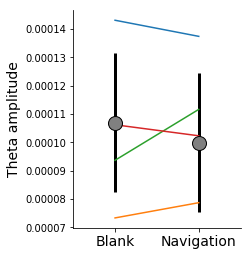

In [1046]:
mm_n = theta_amp_rest_vs_navigation.groupby(['sub']).mean()['amp_nav'].median()
# ss_n = theta_amp_rest_vs_navigation.groupby(['sub']).mean()['amp_nav'].sem()
ss_n = statsmodels.robust.scale.mad(theta_amp_rest_vs_navigation.groupby(['sub']).mean()['amp_nav'].values)

mm_r = theta_amp_rest_vs_navigation.groupby(['sub']).mean()['amp_rest'].median()
# ss_r = theta_amp_rest_vs_navigation.groupby(['sub']).mean()['amp_rest'].sem()
ss_r = statsmodels.robust.scale.mad(theta_amp_rest_vs_navigation.groupby(['sub']).mean()['amp_rest'].values)


fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)
fig.set_facecolor('white')

plt.errorbar(  [0,1], [mm_r,mm_n], yerr=[ss_r,ss_n], color='k', linestyle='', linewidth=3, marker='o', 
               markersize=14, markerfacecolor='grey')

# # Add significance text and bar
# ind = [0,1]
# menMeans = [mm_r,mm_n]
# if stats.ttest_ind( theta_amp_rest_vs_navigation['amp_nav'],
#                    theta_amp_rest_vs_navigation['amp_rest'])[1] < 0.01:
#     pval_str = 'p < 0.01'
# label_diff(0,1,pval_str,ind,menMeans)

# mm_r_a = theta_amp_rest_vs_navigation.groupby(['sub']).mean()['freq_rest'].values
# mm_n_a = theta_amp_rest_vs_navigation.groupby(['sub']).mean()['freq_nav'].values
# plt.plot([0,1] , [mm_r_a,mm_n_a])

plt.plot([0,1],[theta_amp_rest_vs_navigation.groupby(['sub']).mean()['amp_nav'].values,theta_amp_rest_vs_navigation.groupby(['sub']).mean()['amp_rest'].values])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlim(-.5,1.5)
# plt.ylim(5.68,  np.max([mm_r,mm_n])*1.013 )
plt.sca(ax)
plt.ylabel('Theta amplitude', fontsize=14)
plt.xticks(  [0,1], ['Blank', 'Navigation'], fontsize=14)
# plt.tight_layout()

# plt.tight_layout()
# plt.savefig('Figures/theta_amp_rest_vs_navigation.pdf')

# Power throughout navigation (time/freq)

In [425]:
subs_id = {}
for ii in ttl_info_dict:
    if ttl_info_dict[ii]['subject'] not in subs_id:
        subs_id[ttl_info_dict[ii]['subject']] = []
    subs_id[ttl_info_dict[ii]['subject']].append(ii)
subs_id

{0: [0, 1, 2], 1: [3, 4], 3: [6, 7, 8], 4: [9]}

In [1113]:
freqs = np.logspace(*np.log10([1,40]), num=60)
duration = 5.
times = np.linspace(-1, duration, power.shape[1] )

def get_power(epoched_data):    
    n_cycles = freqs / 2.  # different number of cycle per frequency
    power = mne.time_frequency.tfr_array_multitaper(  np.expand_dims(epoched_data,axis=1) ,raw.info['sfreq'], 
                                                freqs=freqs, n_cycles=n_cycles, use_fft=True,
                                                output='avg_power',decim=1, n_jobs=-1,verbose=False)
    power = power[0]
    return power



    

all_subs_power = []
for ii in ttl_info_dict:
    
    epoched_data = []

    filename = 'data/sub_'+str(ttl_info_dict[ii]['subject'])+'_session_'+str(ttl_info_dict[ii]['session'])+'_raw.fif'
    raw = mne.io.read_raw_fif(filename, preload=True)
    trials = ttl_info_dict[ii]['markers']

    if trials.size == 27:
        for cc in range(len(ttl_info_dict[ii]['hpc_channels_idx'])):
            ch_indx = ttl_info_dict[ii]['hpc_channels_idx'][cc]
            ch_name = ttl_info_dict[ii]['hpc_channels_name'][cc]

            raw_copy = raw.copy().pick_channels([ch_name])
            raw_copy.notch_filter([50.,100.,150.,200.],notch_widths=2.)
#             raw_copy.filter(3,10,fir_design='firwin')
            
            channel_data = raw_copy.get_data()[0]            
            channel_data -= np.mean(channel_data)
            
#             channel_data = mne.filter.filter_data(channel_data, raw.info['sfreq'], 3,20 )

            win = 5. * raw.info['sfreq']
            for tt in range(trials.size):

                start = int(trials[tt] - raw.info['sfreq'])
                stop  = int(start + (raw.info['sfreq']*6))
                trial_data = channel_data[start:stop]
                epoched_data.append(trial_data)

    
    epoched_data = np.array(epoched_data)
    if epoched_data.size>0:
        power = get_power(epoched_data)    
        all_subs_power.append(power)
    
all_subs_power = np.array(all_subs_power)
    
    

Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_0_raw.fif...
Isotrak not found
    Range : 142000 ... 350000 =    284.000 ...   700.000 secs
Ready.
Reading 0 ... 208000  =      0.000 ...   416.000 secs...
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_1_raw.fif...
Isotrak not found
    Range : 350000 ... 560000 =    700.000 ...  1120.000 secs
Ready.
Reading 0 ... 210000  =      0.000 ...   420.000 secs...
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-stop filter
Filter length of 3301 sample

Text(0.5, 0, 'Time (sec)')

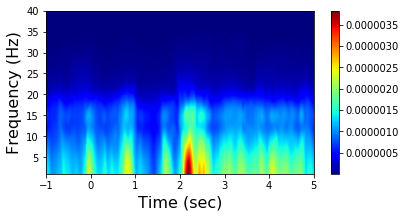

In [1121]:
# tmp_power = np.mean(stats.zscore(all_subs_power,axis=-1),axis=0)
tmp_power = np.median(all_subs_power,axis=0)

fig = plt.figure(figsize=(6,3))
fig.set_facecolor('white')
plt.imshow(  tmp_power, interpolation='gaussian',
           extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', cmap='jet')
plt.colorbar()
plt.ylabel('Frequency (Hz)', fontsize=16)
plt.xlabel('Time (sec)', fontsize=16)

# plt.ylim(1,10)
# plt.xlim(1.2)
# plt.clim(-.27,-.25)

# plt.tight_layout()
# plt.savefig('Figures/power_spectrogram.pdf')

# Inter trial phase coherence at movement onset

In [936]:
freqs = np.logspace(*np.log10([1,40]), num=60)
duration = 5.
times = np.linspace(-1, duration, power.shape[1] )

def get_itpc(epoched_data):    
    n_cycles = freqs / 2.  # different number of cycle per frequency
    itpc = mne.time_frequency.tfr_array_multitaper(  np.expand_dims(epoched_data,axis=1) ,raw.info['sfreq'], 
                                                freqs=freqs, n_cycles=n_cycles, use_fft=True,
                                                output='itc',decim=1, n_jobs=-1,verbose=False)
    itpc = itpc[0]
    return itpc



    

all_subs_itpc = []
for ii in ttl_info_dict:
    
    epoched_data = []

    filename = 'data/sub_'+str(ttl_info_dict[ii]['subject'])+'_session_'+str(ttl_info_dict[ii]['session'])+'_raw.fif'
    raw = mne.io.read_raw_fif(filename, preload=True)
    trials = ttl_info_dict[ii]['markers']

    if trials.size == 27:
        for cc in range(len(ttl_info_dict[ii]['hpc_channels_idx'])):
            ch_indx = ttl_info_dict[ii]['hpc_channels_idx'][cc]
            ch_name = ttl_info_dict[ii]['hpc_channels_name'][cc]

            raw_copy = raw.copy().pick_channels([ch_name])
            raw_copy.notch_filter([50.,100.,150.,200.],notch_widths=2.)

            channel_data = raw_copy.get_data()[0]
            channel_data = mne.filter.filter_data(channel_data, raw.info['sfreq'], 1,85 )

            win = 5. * raw.info['sfreq']
            for tt in range(trials.size):

                start = int(trials[tt] - raw.info['sfreq'])
                stop  = int(start + (raw.info['sfreq']*6))
                trial_data = channel_data[start:stop]
                epoched_data.append(trial_data)

        epoched_data = np.array(epoched_data)    
        itpc = get_itpc(epoched_data)    
        all_subs_itpc.append(itpc)
    
all_subs_itpc = np.array(all_subs_itpc)
    
    

Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_0_raw.fif...
Isotrak not found
    Range : 142000 ... 350000 =    284.000 ...   700.000 secs
Ready.
Reading 0 ... 208000  =      0.000 ...   416.000 secs...
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-pass filter from 1 - 85 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 21.2 Hz
Filter length of 1651 samples (3.302 sec) selected
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-pass filter from 1 - 85 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 21.2 Hz
Filter length of 1651 samples (3.302 sec) selected
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-pass filter from 1 - 85 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 21.2 Hz
Filter length of 1651 samples (3.302 sec) selected
Setting up band

Setting up band-pass filter from 1 - 85 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 21.2 Hz
Filter length of 1651 samples (3.302 sec) selected
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-pass filter from 1 - 85 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 21.2 Hz
Filter length of 1651 samples (3.302 sec) selected


Text(0.5, 0, 'Time (sec)')

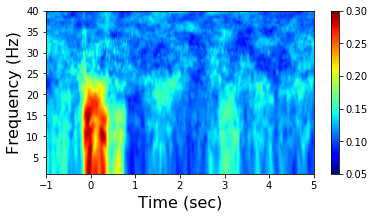

In [943]:
# tmp_power = np.median(stats.zscore(all_subs_itpc,axis=2),axis=0)
tmp_itpc = np.mean(all_subs_itpc,axis=0)

fig = plt.figure(figsize=(6,3))
fig.set_facecolor('white')
plt.imshow(  tmp_itpc[:,:], interpolation='gaussian',
           extent=[times[0], times[-1], freqs[0], freqs[-1]],
           aspect='auto', origin='lower', cmap='jet', vmin=0.05, vmax=.3)
plt.colorbar()
plt.ylabel('Frequency (Hz)', fontsize=16)
plt.xlabel('Time (sec)', fontsize=16)

# plt.ylim(1,10)
# plt.xlim(1.2)
# plt.clim(-.27,-.25)

# plt.tight_layout()
# plt.savefig('Figures/inter_trial_phase_coherence.pdf')

# Dominant frequency

In [1069]:
subs_psd = []
for ii in ttl_info_dict:

    filename = 'data/sub_'+str(ttl_info_dict[ii]['subject'])+'_session_'+str(ttl_info_dict[ii]['session'])+'_raw.fif'
    
    
    raw = mne.io.read_raw_fif(filename, preload=True)
    trials = ttl_info_dict[ii]['markers']
    
    
    if trials.size == 27:

        print('Sub: ' , ttl_info_dict[ii]['subject'] )
        for cc in range(len(ttl_info_dict[ii]['hpc_channels_idx'])):


            ch_indx = ttl_info_dict[ii]['hpc_channels_idx'][cc]
            ch_name = ttl_info_dict[ii]['hpc_channels_name'][cc]


            print('Channel: ', ch_indx, ch_name )

            raw_copy = raw.copy().pick_channels([ch_name])
            raw_copy.notch_filter([50.,100.,150.,200.],notch_widths=.1)

            win = 5. * raw.info['sfreq']
            for tt in range(trials.size):

                start = trials[tt]
                stop  = int(start + (raw.info['sfreq']*5))

                freqs, psd = signal.welch(raw_copy.get_data(start=start,stop=stop)[0], raw.info['sfreq'], nperseg=win)

                fmin=2
                fmax=10
#                 fmin=40
#                 fmax=80
        
                fmin_idx = np.argmin(np.abs(freqs-fmin))
                fmax_idx = np.argmin(np.abs(freqs-fmax))
                

                psd   = psd[fmin_idx:fmax_idx]
                freqs = freqs[fmin_idx:fmax_idx]
                            
                smooth_psd_sz         = 3
                smooth_psd_sigma      = 2
                psd = smooth_psd(psd, sz=smooth_psd_sz, sigma=smooth_psd_sigma)
                peakkss = scipy.signal.find_peaks(psd)[0]
                peakkss = np.mean(freqs[peakkss])

                csw = np.argmin(np.abs(unii[tt]-np.linspace(2,14,5)))
                
                subs_psd.append( [ ttl_info_dict[ii]['subject'], ttl_info_dict[ii]['session'], ch_name, speed[tt], density[tt], unii[tt], csw, peakkss ]  )

                
                
columns=['sub','session','channel','speed','density','cuesec','csw','peakkss'] 
subs_psd = pd.DataFrame(subs_psd,columns=columns )

# subs_psd_40_80 = np.copy(subs_psd)  ## Saved subs psd for 40-80Hz

Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_0_raw.fif...
Isotrak not found
    Range : 142000 ... 350000 =    284.000 ...   700.000 secs
Ready.
Reading 0 ... 208000  =      0.000 ...   416.000 secs...
Sub:  0
Channel:  47 B1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  48 B2
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  55 C1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  56 C2
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_1_raw.fif...
Isotrak not found
    Range : 350000 ... 560000 =    700.000 ...  1120.000 secs
Ready.
Reading 0 ... 210000  =      0.000 ...   420.000 secs...
Sub:  0
Channel:  47 B1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  48 B2
Setting up band-stop fi

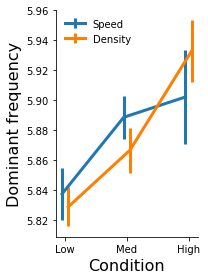

In [1070]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)
fig.set_facecolor('white')

mmm = subs_psd.groupby(['speed','sub']).mean()['peakkss'].unstack().T.mean()
sss = subs_psd.groupby(['speed','sub']).mean()['peakkss'].unstack().T.sem()
plt.errorbar(  np.arange(3)-0.05, mmm, yerr=sss, label='Speed', linewidth=3, color=plo['speed_color'] )

mmm = subs_psd.groupby(['density','sub']).mean()['peakkss'].unstack().T.mean()
sss = subs_psd.groupby(['density','sub']).mean()['peakkss'].unstack().T.sem()
plt.errorbar(  np.arange(3)+0.05, mmm, yerr=sss, label='Density', linewidth=3, color=plo['density_color'] )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.legend( frameon=False, loc='upper left')
plt.xlabel('Condition', fontsize=16)
plt.ylabel('Dominant frequency', fontsize=16)
plt.xticks(range(3), ['Low','Med','High']);

# plt.ylim(38.7,39.2)

plt.tight_layout()
# plt.savefig('Figures/theta_dominant_freq_speed_density.pdf')

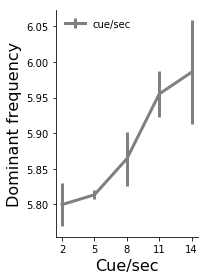

In [766]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)
fig.set_facecolor('white')

mmm = subs_psd.groupby(['csw','sub']).median()['peakkss'].unstack().T.median()
sss = subs_psd.groupby(['csw','sub']).median()['peakkss'].unstack().T.sem()
plt.errorbar(  np.linspace(2,14,mmm.size), mmm, yerr=sss, label='cue/sec', linewidth=3, color=plo['cuesec_color'] )


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.legend( frameon=False, loc='upper left')
plt.xlabel('Cue/sec', fontsize=16)
plt.ylabel('Dominant frequency', fontsize=16)
# plt.xticks(range(3), ['Low','Med','High']);
plt.xticks(  np.linspace(2,14,mmm.index.size).astype(int) );

# plt.ylim(38.7,39.2)
plt.tight_layout()
# plt.savefig('Figures/theta_dominant_freq_cuesec.pdf')





---------------------------------------------
Speed
FriedmanchisquareResult(statistic=2.0, pvalue=0.36787944117144245)
             sum_sq     df         F    PR(>F)
peakkss     0.93191    1.0  1.396664  0.237684
Residual  467.06809  700.0       NaN       NaN




---------------------------------------------
Density
FriedmanchisquareResult(statistic=6.5, pvalue=0.03877420783172202)


              sum_sq     df         F    PR(>F)
peakkss     3.641878    1.0  5.489976  0.019405
Residual  464.358122  700.0       NaN       NaN




---------------------------------------------
csw
FriedmanchisquareResult(statistic=10.200000000000003, pvalue=0.037190154049645326)
              sum_sq     df         F    PR(>F)
peakkss    10.508230    1.0  8.257245  0.004182
Residual  890.825104  700.0       NaN       NaN




Posthoc


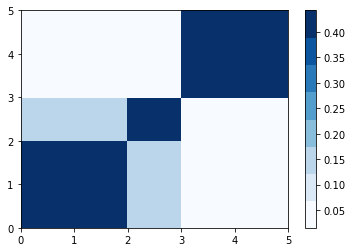

In [129]:
print('\n\n\n')
print('---------------------------------------------')
print('Speed')
mmm = subs_psd.groupby(['speed','sub']).median()['peakkss'].unstack()
mmm_np = mmm.to_numpy()
print( stats.friedmanchisquare(  *[mmm_np[ii] for ii in range(mmm_np.shape[0])] ))
cw_lm=ols('speed ~ peakkss', data=subs_psd).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

print('\n\n\n')
print('---------------------------------------------')
print('Density')
mmm = subs_psd.groupby(['density','sub']).median()['peakkss'].unstack()
mmm_np = mmm.to_numpy()
print( stats.friedmanchisquare(  *[mmm_np[ii] for ii in range(mmm_np.shape[0])] ))
print('\n')
cw_lm=ols('density ~ peakkss', data=subs_psd).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))



print('\n\n\n')
print('---------------------------------------------')
print('csw')
mmm = subs_psd.groupby(['csw','sub']).median()['peakkss'].unstack()
mmm_np = mmm.to_numpy()
print( stats.friedmanchisquare(  *[mmm_np[ii] for ii in range(mmm_np.shape[0])] ))
cw_lm=ols('csw ~ peakkss', data=subs_psd).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

print('\n\n\n')


print('Posthoc')

subs_psd_np = subs_psd.to_numpy()

psd_np = []
for sub in np.unique(subs_psd_np[:,0]):
    tmp = []
    for csw in np.unique(subs_psd_np[:,6]):        
        idx = np.where(np.logical_and( subs_psd_np[:,0]==sub, subs_psd_np[:,6]==csw ))[0]
        tmp.append( np.mean(subs_psd_np[idx,7]) )
    psd_np.append(tmp)
psd_np = np.array(psd_np)

wc_pval = np.zeros((5,5))
for x in range(5):
    for y in range(5):
        wc_pval[x,y]=stats.mannwhitneyu(psd_np[:,x],psd_np[:,y])[1]    

plt.pcolor(wc_pval, cmap=plt.cm.get_cmap('Blues', 8))
plt.colorbar()

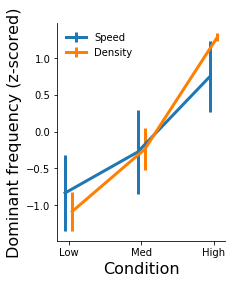

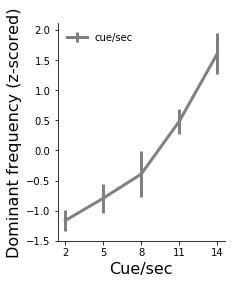

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)
fig.set_facecolor('white')

mmm = subs_psd.groupby(['speed','sub']).median()['peakkss'].unstack().apply(stats.zscore).T.median()
sss = subs_psd.groupby(['speed','sub']).median()['peakkss'].unstack().apply(stats.zscore).T.sem()
plt.errorbar(  np.arange(3)-0.05, mmm, yerr=sss, label='Speed', linewidth=3,color=plo['speed_color'] )

mmm = subs_psd.groupby(['density','sub']).median()['peakkss'].unstack().apply(stats.zscore).T.median()
sss = subs_psd.groupby(['density','sub']).median()['peakkss'].unstack().apply(stats.zscore).T.sem()
plt.errorbar(  np.arange(3)+0.05, mmm, yerr=sss, label='Density', linewidth=3, color=plo['density_color'] )



ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.legend( frameon=False, loc='upper left')
plt.xlabel('Condition', fontsize=16)
plt.ylabel('Dominant frequency (z-scored)', fontsize=16)
plt.xticks(range(3), ['Low','Med','High']);






fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)
fig.set_facecolor('white')

mmm = subs_psd.groupby(['csw','sub']).median()['peakkss'].unstack().apply(stats.zscore).T.median()
sss = subs_psd.groupby(['csw','sub']).median()['peakkss'].unstack().apply(stats.zscore).T.sem()
plt.errorbar(  np.linspace(2,14,mmm.size), mmm, yerr=sss, label='cue/sec', linewidth=3,color=plo['cuesec_color'] )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.legend( frameon=False, loc='upper left')
plt.xlabel('Cue/sec', fontsize=16)
plt.ylabel('Dominant frequency (z-scored)', fontsize=16)
plt.xticks(  np.linspace(2,14,mmm.index.size).astype(int) );

# Oscilatory band amplitude in cue/sec

In [24]:
low_amp_freq = 2
high_amp_freq = 8

subs_amp_gamma = []
for ii in ttl_info_dict:

    filename = 'data/sub_'+str(ttl_info_dict[ii]['subject'])+'_session_'+str(ttl_info_dict[ii]['session'])+'_raw.fif'
    
    raw = mne.io.read_raw_fif(filename, preload=True)
    trials = ttl_info_dict[ii]['markers']
    
    if trials.size == 27:

        print('Sub: ' , ttl_info_dict[ii]['subject'] )
        for cc in range(len(ttl_info_dict[ii]['hpc_channels_idx'])):


            ch_indx = ttl_info_dict[ii]['hpc_channels_idx'][cc]
            ch_name = ttl_info_dict[ii]['hpc_channels_name'][cc]


            print('Channel: ', ch_indx, ch_name )

            raw_copy = raw.copy().pick_channels([ch_name])
            raw_copy.notch_filter([50.,100.,150.,200.],notch_widths=.1)
            

            tmp_gamma_amp = hilbert_transform_get_component( raw_copy.get_data()[0] , raw.info['sfreq'], low_amp_freq,high_amp_freq, 'amplitude')

            for tt in range(trials.size):

                start = trials[tt]
                stop  = int(start + (raw.info['sfreq']*5))

                g_amp = np.mean(tmp_gamma_amp[start:stop])
        
                csw = np.argmin(np.abs(unii[tt]-np.linspace(2,14,5)))                
                subs_amp_gamma.append( [ ttl_info_dict[ii]['subject'], ttl_info_dict[ii]['session'], ch_name, speed[tt], density[tt], unii[tt], csw, g_amp ]  )

                
columns=['sub','session','channel','speed','density','cuesec','csw','gamma_amp'] 
subs_amp_gamma = pd.DataFrame(subs_amp_gamma,columns=columns )

Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_0_raw.fif...
Isotrak not found
    Range : 142000 ... 350000 =    284.000 ...   700.000 secs
Ready.
Reading 0 ... 208000  =      0.000 ...   416.000 secs...
Sub:  0
Channel:  47 B1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Channel:  48 B2
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Channel:  55 C1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Channel:  56 C2
Setting up band-stop filter
Filter length of 3301 samples (6.602 s

(6e-05, 0.00014)

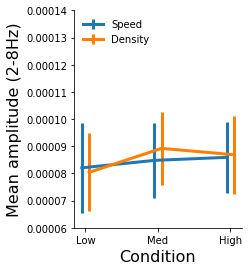

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)
fig.set_facecolor('white')

mmm = subs_amp_gamma.groupby(['speed','sub']).median()['gamma_amp'].unstack().T.median()
sss = subs_amp_gamma.groupby(['speed','sub']).median()['gamma_amp'].unstack().T.sem()
plt.errorbar(  np.arange(3)-0.05, mmm, yerr=sss, label='Speed', linewidth=3, color=plo['speed_color'] )

mmm = subs_amp_gamma.groupby(['density','sub']).median()['gamma_amp'].unstack().T.median()
sss = subs_amp_gamma.groupby(['density','sub']).median()['gamma_amp'].unstack().T.sem()
plt.errorbar(  np.arange(3)+0.05, mmm, yerr=sss, label='Density', linewidth=3, color=plo['density_color'] )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.legend( frameon=False, loc='upper left')
plt.xlabel('Condition', fontsize=16)
plt.ylabel('Mean amplitude ('+str(low_amp_freq)+'-'+str(high_amp_freq)+'Hz)', fontsize=16)
plt.xticks(range(3), ['Low','Med','High']);

plt.ylim(0.00006,0.00014)

(6e-05, 0.00014)

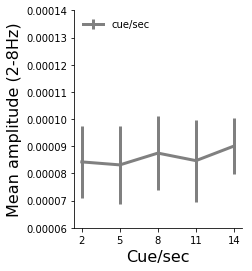

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)
fig.set_facecolor('white')

mmm = subs_amp_gamma.groupby(['csw','sub']).median()['gamma_amp'].unstack().T.median()
sss = subs_amp_gamma.groupby(['csw','sub']).median()['gamma_amp'].unstack().T.sem()
plt.errorbar(  np.linspace(2,14,mmm.size), mmm, yerr=sss, label='cue/sec', linewidth=3, color=plo['cuesec_color'] )


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.legend( frameon=False, loc='upper left')
plt.xlabel('Cue/sec', fontsize=16)
plt.ylabel('Mean amplitude ('+str(low_amp_freq)+'-'+str(high_amp_freq)+'Hz)', fontsize=16)
# plt.xticks(range(3), ['Low','Med','High']);
plt.xticks(  np.linspace(2,14,mmm.index.size).astype(int) );

plt.ylim(0.00006,0.00014)





---------------------------------------------
Speed
FriedmanchisquareResult(statistic=0.5, pvalue=0.7788007830714049)
               sum_sq     df         F    PR(>F)
gamma_amp    0.189185    1.0  0.283084  0.594856
Residual   467.810815  700.0       NaN       NaN




---------------------------------------------
Density
FriedmanchisquareResult(statistic=6.0, pvalue=0.04978706836786395)


               sum_sq     df        F    PR(>F)
gamma_amp    0.238732    1.0  0.35726  0.550225
Residual   467.761268  700.0      NaN       NaN




---------------------------------------------
csw
FriedmanchisquareResult(statistic=1.7999999999999972, pvalue=0.7724823535071388)
               sum_sq     df         F    PR(>F)
gamma_amp    0.100896    1.0  0.078367  0.779605
Residual   901.232437  700.0       NaN       NaN




Posthoc


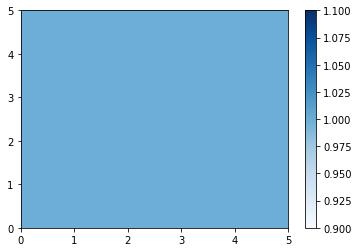

In [132]:
print('\n\n\n')
print('---------------------------------------------')
print('Speed')
mmm = subs_amp_gamma.groupby(['speed','sub']).median()['gamma_amp'].unstack()
mmm_np = mmm.to_numpy()
print( stats.friedmanchisquare(  *[mmm_np[ii] for ii in range(mmm_np.shape[0])] ))
cw_lm=ols('speed ~ gamma_amp', data=subs_amp_gamma).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

print('\n\n\n')
print('---------------------------------------------')
print('Density')
mmm = subs_amp_gamma.groupby(['density','sub']).median()['gamma_amp'].unstack()
mmm_np = mmm.to_numpy()
print( stats.friedmanchisquare(  *[mmm_np[ii] for ii in range(mmm_np.shape[0])] ))
print('\n')
cw_lm=ols('density ~ gamma_amp', data=subs_amp_gamma).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))



print('\n\n\n')
print('---------------------------------------------')
print('csw')
mmm = subs_amp_gamma.groupby(['csw','sub']).median()['gamma_amp'].unstack()
mmm_np = mmm.to_numpy()
print( stats.friedmanchisquare(  *[mmm_np[ii] for ii in range(mmm_np.shape[0])] ))
cw_lm=ols('csw ~ gamma_amp', data=subs_amp_gamma).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

print('\n\n\n')


print('Posthoc')

subs_amp_gamma_np = subs_amp_gamma.to_numpy()

amp_gamma_np = []
for sub in np.unique(subs_amp_gamma_np[:,0]):
    tmp = []
    for csw in np.unique(subs_amp_gamma_np[:,6]):        
        idx = np.where(np.logical_and( subs_amp_gamma_np[:,0]==sub, subs_amp_gamma_np[:,6]==csw ))[0]
        tmp.append( np.mean(subs_amp_gamma_np[idx,7]) )
    amp_gamma_np.append(tmp)
amp_gamma_np = np.array(amp_gamma_np)

wc_pval = np.zeros((5,5))
for x in range(5):
    for y in range(5):
        wc_pval[x,y]=stats.mannwhitneyu(amp_gamma_np[:,x],amp_gamma_np[:,y])[1]    

        
wc_pval[wc_pval<=0.1]=0
wc_pval[wc_pval>0.1]=1
plt.pcolor(wc_pval, cmap='Blues')
plt.colorbar()

# Dominant freq at rest vs navigation

In [764]:
dominant_freq_rest_vs_navigation = []
for ii in ttl_info_dict:

    filename = 'data/sub_'+str(ttl_info_dict[ii]['subject'])+'_session_'+str(ttl_info_dict[ii]['session'])+'_raw.fif'
    
    
    raw = mne.io.read_raw_fif(filename, preload=True)
    trials = ttl_info_dict[ii]['markers']
    
    
    if trials.size == 27:

        print('Sub: ' , ttl_info_dict[ii]['subject'] )
        for cc in range(len(ttl_info_dict[ii]['hpc_channels_idx'])):


            ch_indx = ttl_info_dict[ii]['hpc_channels_idx'][cc]
            ch_name = ttl_info_dict[ii]['hpc_channels_name'][cc]


            print('Channel: ', ch_indx, ch_name )

            raw_copy = raw.copy().pick_channels([ch_name])
            raw_copy.notch_filter([50.,100.,150.,200.],notch_widths=.1)


            win = 3. * raw.info['sfreq']
            for tt in range(1,trials.size):

                def get_peaks(psd,freqs):
                    fmin=2
                    fmax=10
                    fmin_idx = np.argmin(np.abs(freqs-fmin))
                    fmax_idx = np.argmin(np.abs(freqs-fmax))

                    psd   = psd[fmin_idx:fmax_idx]
                    freqs = freqs[fmin_idx:fmax_idx]

                    smooth_psd_sz         = 3
                    smooth_psd_sigma      = 2
                    psd = smooth_psd(psd, sz=smooth_psd_sz, sigma=smooth_psd_sigma)
                    peakkss = scipy.signal.find_peaks(psd)[0]
                    peakkss = np.mean(freqs[peakkss])
                    return peakkss

                
                start = trials[tt] + 200#raw.info['sfreq']*1
                stop  = int(start + (raw.info['sfreq']*3))
                freqs, psd = signal.welch(raw_copy.get_data(start=start,stop=stop)[0], raw.info['sfreq'], nperseg=win)
                freq_nav = get_peaks(psd,freqs)

                start = trials[tt]
                stop  = int(start - (raw.info['sfreq']*3))
                freqs, psd = signal.welch(raw_copy.get_data(start=stop,stop=start)[0], raw.info['sfreq'], nperseg=win)
                freq_rest = get_peaks(psd,freqs)

                dominant_freq_rest_vs_navigation.append( [ ttl_info_dict[ii]['subject'], ttl_info_dict[ii]['session'], ch_name, freq_rest,freq_nav  ]  )

                
                
columns=['sub','session','channel','freq_rest','freq_nav']
dominant_freq_rest_vs_navigation = pd.DataFrame(dominant_freq_rest_vs_navigation,columns=columns )


Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_0_raw.fif...
Isotrak not found
    Range : 142000 ... 350000 =    284.000 ...   700.000 secs
Ready.
Reading 0 ... 208000  =      0.000 ...   416.000 secs...
Sub:  0
Channel:  47 B1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  48 B2
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  55 C1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  56 C2
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_1_raw.fif...
Isotrak not found
    Range : 350000 ... 560000 =    700.000 ...  1120.000 secs
Ready.
Reading 0 ... 210000  =      0.000 ...   420.000 secs...
Sub:  0
Channel:  47 B1
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Channel:  48 B2
Setting up band-stop fi

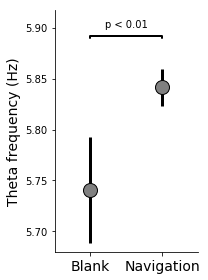

In [765]:
mm_n = dominant_freq_rest_vs_navigation.groupby(['sub']).mean()['freq_nav'].median()
# ss_n = dominant_freq_rest_vs_navigation.groupby(['sub']).mean()['freq_nav'].sem()
ss_n = statsmodels.robust.scale.mad(dominant_freq_rest_vs_navigation.groupby(['sub']).mean()['freq_nav'].values)

mm_r = dominant_freq_rest_vs_navigation.groupby(['sub']).mean()['freq_rest'].median()
# ss_r = dominant_freq_rest_vs_navigation.groupby(['sub']).mean()['freq_rest'].sem()
ss_r = statsmodels.robust.scale.mad(dominant_freq_rest_vs_navigation.groupby(['sub']).mean()['freq_rest'].values)


fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)
fig.set_facecolor('white')

plt.errorbar(  [0,1], [mm_r,mm_n], yerr=[ss_r,ss_n], color='k', linestyle='', linewidth=3, marker='o', 
               markersize=14, markerfacecolor='grey')

# Add significance text and bar
ind = [0,1]
menMeans = [mm_r,mm_n]
if stats.ttest_ind( dominant_freq_rest_vs_navigation['freq_nav'],
                   dominant_freq_rest_vs_navigation['freq_rest'])[1] < 0.01:
    pval_str = 'p < 0.01'
label_diff(0,1,pval_str,ind,menMeans)

# mm_r_a = dominant_freq_rest_vs_navigation.groupby(['sub']).mean()['freq_rest'].values
# mm_n_a = dominant_freq_rest_vs_navigation.groupby(['sub']).mean()['freq_nav'].values
# plt.plot([0,1] , [mm_r_a,mm_n_a])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlim(-.5,1.5)
plt.ylim(5.68,  np.max([mm_r,mm_n])*1.013 )
plt.sca(ax)
plt.ylabel('Theta frequency (Hz)', fontsize=14)
plt.xticks(  [0,1], ['Blank', 'Navigation'], fontsize=14)
plt.tight_layout()

plt.tight_layout()
plt.savefig('Figures/theta_dominant_freq_navigation_vs_blank.pdf')

# Welch's periodogram

In [761]:
ii = 0

filename = 'data/sub_'+str(ttl_info_dict[ii]['subject'])+'_session_'+str(ttl_info_dict[ii]['session'])+'_raw.fif'


raw = mne.io.read_raw_fif(filename, preload=True)
trials = ttl_info_dict[ii]['markers']


tmp_psd =[]

for cc in range(len(ttl_info_dict[ii]['hpc_channels_idx'])):


    ch_indx = ttl_info_dict[ii]['hpc_channels_idx'][cc]
    ch_name = ttl_info_dict[ii]['hpc_channels_name'][cc]

    raw_copy = raw.copy().pick_channels([ch_name])
    raw_copy.notch_filter([50.,100.,150.,200.],notch_widths=.1)

    win = 5. * raw.info['sfreq']

    freqs, psd = signal.welch(raw_copy.get_data()[0], raw.info['sfreq'], nperseg=win)
    tmp_psd.append(psd)


tmp_psd = np.array(tmp_psd)


mean_psd = np.mean(tmp_psd,axis=0)
sem_psd = stats.sem(tmp_psd,axis=0)

Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_0_raw.fif...
Isotrak not found
    Range : 142000 ... 350000 =    284.000 ...   700.000 secs
Ready.
Reading 0 ... 208000  =      0.000 ...   416.000 secs...
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected


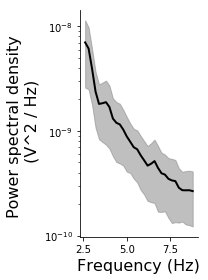

In [762]:
fmin,fmax = 2.6,9
fmin_idx = np.argmin(np.abs(freqs-fmin))
fmax_idx = np.argmin(np.abs(freqs-fmax))


# plt.figure(figsize=(8, 4))
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)
fig.set_facecolor('white')


plt.semilogy(freqs[fmin_idx:fmax_idx], mean_psd[fmin_idx:fmax_idx], color='k', lw=2)
plt.fill_between(freqs[fmin_idx:fmax_idx], mean_psd[fmin_idx:fmax_idx]-sem_psd[fmin_idx:fmax_idx],
                                           mean_psd[fmin_idx:fmax_idx]+sem_psd[fmin_idx:fmax_idx],alpha=0.5, color='grey')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Power spectral density \n (V^2 / Hz)', fontsize=16)


plt.tight_layout()
plt.savefig('Figures/psd_theta_all.pdf')



In [754]:
fmin=1
fmax=10

psd_psd   = []
psd_freqs = []
for ii in ttl_info_dict:

    
    filename = 'data/sub_'+str(ttl_info_dict[ii]['subject'])+'_session_'+str(ttl_info_dict[ii]['session'])+'_raw.fif'
    raw = mne.io.read_raw_fif(filename, preload=True)
    win = 5. * raw.info['sfreq']
    idx_trials = ttl_info_dict[ii]['markers']
    

    if len(idx_trials)==27:
        for ch_name in ttl_info_dict[ii]['hpc_channels_name']:           

            raw_copy = raw.copy().pick_channels([ch_name])
            raw_copy.notch_filter([50.,100.,150.,200.],notch_widths=.1)

            for trial in range(len(idx_trials)):

                csw = np.argmin(np.abs(unii[trial]-np.linspace(2,14,5)))

                if csw<2:
#                 if csw>=2 and csw<4:


                    start = idx_trials[trial]
                    stop  = int(start + (raw.info['sfreq']*5))

                    freqs, psd = signal.welch(raw_copy.get_data(start=start,stop=stop)[0], raw.info['sfreq'], nperseg=win )

            
                    smooth_psd_sz         = 3
                    smooth_psd_sigma      = 2
                    psd = smooth_psd(psd, sz=smooth_psd_sz, sigma=smooth_psd_sigma)

            
                    psd_psd.append(psd)
                    psd_freqs.append(freqs)
                    
        
psd_psd = np.array(psd_psd)
psd_freqs = np.array(psd_freqs)

Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_0_raw.fif...
Isotrak not found
    Range : 142000 ... 350000 =    284.000 ...   700.000 secs
Ready.
Reading 0 ... 208000  =      0.000 ...   416.000 secs...
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Opening raw data file /Users/diogo/Desktop/Normaliser_2019/data/sub_0_session_1_raw.fif...
Isotrak not found
    Range : 350000 ... 560000 =    700.000 ...  1120.000 secs
Ready.
Reading 0 ... 210000  =      0.000 ...   420.000 secs...
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-stop filter
Filter length of 3301 samples (6.602 sec) selected
Setting up band-stop filter
Filter length of 3301 sample

In [755]:
psd_psd_low_cs = np.copy(psd_psd)
psd_freqs_low_cs = np.copy(psd_freqs)

# psd_psd_high_cs = np.copy(psd_psd)
# psd_freqs_high_cs = np.copy(psd_freqs)

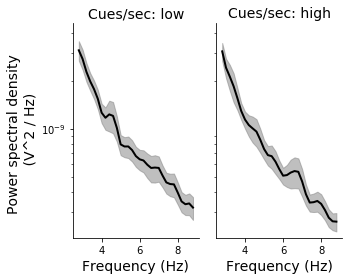

In [759]:
fmin,fmax = 2.8,9
fmin_idx = np.argmin(np.abs(freqs-fmin))
fmax_idx = np.argmin(np.abs(freqs-fmax))

fig , ax = plt.subplots(1,2)
# fig = plt.figure()
# ax = fig.subplots(111)
fig.set_figheight(4)
fig.set_figwidth(5)
fig.set_facecolor('white')

for lh in range(2):
    
    plt.sca(ax[lh])

    if lh == 0:
        mean_psd = np.mean(psd_psd_low_cs,axis=0)
        sem_psd = stats.sem(psd_psd_low_cs,axis=0)
        plt.title('Cues/sec: low', fontsize=14)
        plt.ylabel('Power spectral density \n (V^2 / Hz)', fontsize=14)


    if lh == 1:
        mean_psd = np.mean(psd_psd_high_cs,axis=0)
        sem_psd = stats.sem(psd_psd_high_cs,axis=0)
        plt.title('Cues/sec: high',fontsize=14)



    plt.semilogy(freqs[fmin_idx:fmax_idx], mean_psd[fmin_idx:fmax_idx], color='k', lw=2)
    plt.fill_between(freqs[fmin_idx:fmax_idx], mean_psd[fmin_idx:fmax_idx]-sem_psd[fmin_idx:fmax_idx],
                                               mean_psd[fmin_idx:fmax_idx]+sem_psd[fmin_idx:fmax_idx],alpha=0.5, color='grey')

    ax[lh].spines['right'].set_visible(False)
    ax[lh].spines['top'].set_visible(False)
    plt.xlabel('Frequency (Hz)',fontsize=14)


    plt.ylim(1*np.e**-22.3 ,1*np.e**-19.2)
    
    if lh == 1: ax[lh].set_yticks([])

plt.tight_layout()
plt.savefig('Figures/psd_theta_low_high_cuesec.pdf')



# PAC

In [119]:

def get_phase_amplitude(l_f_amp,h_f_amp):

    amp_phase = {}

    for ii in ttl_info_dict:

        filename = 'data/sub_'+str(ttl_info_dict[ii]['subject'])+'_session_'+str(ttl_info_dict[ii]['session'])+'_raw.fif'

        amp_phase[ii] = {}
        amp_phase[ii]['info'] = [ttl_info_dict[ii]['subject'],ttl_info_dict[ii]['session']]
        amp_phase[ii]['phase'] = []
        amp_phase[ii]['amp'] = []

        raw = mne.io.read_raw_fif(filename, preload=True, verbose=False)
        trials = ttl_info_dict[ii]['markers']

        if trials.size == 27:

            print('Sub: ' , ttl_info_dict[ii]['subject'] )
            for cc in range(len(ttl_info_dict[ii]['hpc_channels_idx'])):


                ch_indx = ttl_info_dict[ii]['hpc_channels_idx'][cc]
                ch_name = ttl_info_dict[ii]['hpc_channels_name'][cc]


                print('Channel: ', ch_indx, ch_name )

                raw_copy = raw.copy().pick_channels([ch_name])
                raw_copy.notch_filter([50.,100.,150.,200.],notch_widths=.1, verbose=False)

                tmp_lfp = raw_copy.get_data()[0]

                raw_phase, raw_amp = hilbert_transform(tmp_lfp, raw.info['sfreq'],l_f_amp,h_f_amp)

                amp_phase[ii]['phase'].append( raw_phase)
                amp_phase[ii]['amp'].append( raw_amp)
                
                
    return amp_phase


def organize_amp_phase_to_pandas(amp_phase):
    trial_begin           = 0
    trial_end             = 1500#4000
    # trial_begin           = 0
    # trial_end             = 1500


    ## Trial type
    tmp_density = np.tile( np.repeat( np.arange(3), 3 ),3)
    tmp_speed = np.tile( np.arange(3), 9 )
    tmp_dur = [ 18.1, 13.5, 11]
    tmp_dd = [50,100,150]


    log_pac = []
    log_amp_in_phase = []
    for sub in ttl_info_dict:

        idx_trials = trials = ttl_info_dict[sub]['markers']


        for cc in range(len(amp_phase[sub]['amp'])):

            tmp_amp = amp_phase[sub]['amp'][cc]
            tmp_phase = amp_phase[sub]['phase'][cc]


            for trial in range(len(idx_trials)):

                tmp_tmp_amp = tmp_amp[ idx_trials[trial] + trial_begin : idx_trials[trial] + trial_end ]
                tmp_tmp_phase = tmp_phase[ idx_trials[trial] + trial_begin : idx_trials[trial] + trial_end ]

                bs = binned_statistic(tmp_tmp_phase,tmp_tmp_amp,bins=20)
                kb = calculate_KB(bs)

                log_amp_in_phase.append(bs)
                cs = tmp_dd[tmp_density[trial]]/tmp_dur[tmp_speed[trial]]
                csw = np.argmin(np.abs(cs-np.linspace(2,14,5)))
                log_pac.append( [ttl_info_dict[sub]['subject'], tmp_density[trial], tmp_speed[trial], cs, csw, kb] )


    log_pac = pd.DataFrame(log_pac, columns=['sub','density','speed','cuesec','cuesec_w','kb'] )
    
    return log_pac,log_amp_in_phase

In [118]:
def plot_pac_speed_density(log_pac,log_freqs):

    fig = plt.figure()
    ax = fig.add_subplot(111)

    fig.set_figheight(4)
    fig.set_figwidth(3)
    fig.set_facecolor('white')

    var_of_interst = 'kb'

    mmd = log_pac.groupby(['density','sub']).mean()[var_of_interst].unstack().T.median()  #log_pac.groupby(['density']).mean()[var_of_interst]
    mms = log_pac.groupby(['speed','sub']).mean()[var_of_interst].unstack().T.median()  #log_pac.groupby(['speed']).mean()[var_of_interst]
    ssd = log_pac.groupby(['density','sub']).mean()[var_of_interst].unstack().T.sem() #log_pac.groupby(['density']).sem()[var_of_interst]
    sss = log_pac.groupby(['speed','sub']).mean()[var_of_interst].unstack().T.sem() #log_pac.groupby(['speed']).sem()[var_of_interst]

    plt.errorbar(  np.arange(3)-0.05, mms, yerr=sss, label='Speed', linewidth=3 )
    plt.errorbar(  np.arange(3)+0.05, mmd, yerr=ssd, label='Density', linewidth=3  )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.sca(ax)
#     plt.legend( frameon=False, loc='lower left')
    plt.ylabel('PAC (' + str(log_freqs[0]) +'-'+str(log_freqs[1])+'Hz)'  , fontsize=16)
    plt.xlabel('Condition', fontsize=16)
    plt.xticks(range(3), ['Low','Med','High'])
    plt.tight_layout()

#     plt.ylim(0.0015,0.005)  ##55-95
#     plt.ylim(0.002,0.009)   ##15-30
#     plt.ylim(0.002,0.007)   ##30-47
    plt.ylim(0.0028,0.008)

    ym = plt.ylim()[1]*0.95

    log_pac_np_tmp = log_pac.groupby(['density','sub']).mean()[var_of_interst].unstack().T.to_numpy()
    pval_str = np.round(stats.friedmanchisquare(*[ log_pac_np_tmp[:,ii]   for ii in range(log_pac_np_tmp.shape[1]) ])[1],3)
    pval_str = 'p='+str(pval_str)
#     plt.text( 0.4, ym, pval_str,  fontdict=dict(color=plo['density_color']) )
    print('#########  P val density #########')
    print(pval_str)
    print('###########################')


    log_pac_np_tmp = log_pac.groupby(['speed','sub']).mean()[var_of_interst].unstack().T.to_numpy()
    pval_str = np.round(stats.friedmanchisquare(*[ log_pac_np_tmp[:,ii]   for ii in range(log_pac_np_tmp.shape[1]) ])[1],3)
    pval_str = 'p='+str(pval_str)
#     plt.text( 0.4, ym-.0005, pval_str,  fontdict=dict(color=plo['speed_color']) )
    print('#########  P val speed #########')
    print(pval_str)
    print('###########################')


    plt.tight_layout()
#     plt.savefig('Figures/pac_condition.pdf')
    
    
    
def plot_pac_cuesec(log_pac, log_freqs):
    var_of_interst = 'kb'
    mmcs = log_pac.groupby(['cuesec_w','sub']).mean()[var_of_interst].unstack().T.median()  #log_pac.groupby(['density']).mean()[var_of_interst]
    sscs = log_pac.groupby(['cuesec_w','sub']).mean()[var_of_interst].unstack().T.sem() #log_pac.groupby(['density']).sem()[var_of_interst]

    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.set_figheight(4)
    fig.set_figwidth(3)
    fig.set_facecolor('white')

    ym = mmcs.max()*1.1 #sum(plt.ylim())/2
    log_pac_np_tmp = log_pac.groupby(['cuesec_w','sub']).mean()[var_of_interst].unstack().T.to_numpy()
    pval_str = np.round(stats.friedmanchisquare(*[ log_pac_np_tmp[:,ii]   for ii in range(log_pac_np_tmp.shape[1]) ])[1],3)
    pval_str = 'p='+str(pval_str)
#     plt.text( 0.4, ym, pval_str,  fontdict=dict(color=plo['cuesec_color']) )
    print('#########  P val #########')
    print(pval_str)
    print('###########################')

#     plt.ylim(0.0025,0.005)  ##55-95
#     plt.ylim(0.002,0.009)   ##15-30
#     plt.ylim(0.002,0.007)   ##30-47
    plt.ylim(0.0027,0.009)
    
    
    ax.errorbar(  range(mmcs.size), mmcs, yerr=sscs, linewidth=3, label=pval_str, color=plo['cuesec_color'] )

    fig.patch.set_facecolor('xkcd:white')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.sca(ax)
    plt.ylabel('PAC (' + str(log_freqs[0]) +'-'+str(log_freqs[1])+'Hz)'  , fontsize=16)
    plt.xlabel('Cues/sec level', fontsize=16)

    plt.xticks(np.arange(mmcs.size), np.linspace(2,14,mmcs.size).astype(int) );
    plt.tight_layout()
    # plt.savefig('../Figures/pac_cuesec.pdf')


Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  1
Channel:  19 B'1
Channel:  20 B'2
Channel:  29 C'1
Channel:  30 C'2
Sub:  1
Channel:  19 B'1
Channel:  20 B'2
Channel:  29 C'1
Channel:  30 C'2
Sub:  3
Channel:  7 B'1
Channel:  8 B'2
Channel:  15 C'1
Channel:  16 C'2
Sub:  4
Channel:  22 C'1
Channel:  23 C'2
#########  P val density #########
p=0.779
###########################
#########  P val speed #########
p=0.472
###########################
#########  P val #########
p=0.331
###########################
Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  1
Channel:  19 B'1
Channel:  20 B'2
Channel:  29 C'1
Channel:  30 C'2
Sub:  1
Channel:  19 

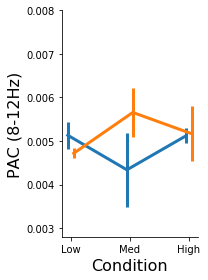

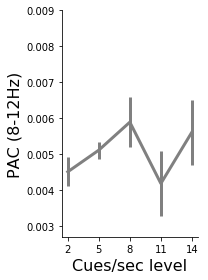

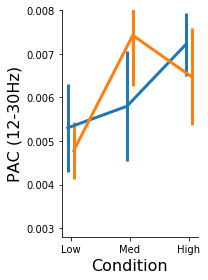

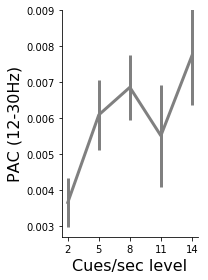

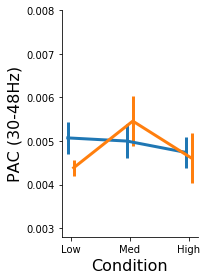

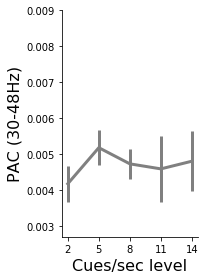

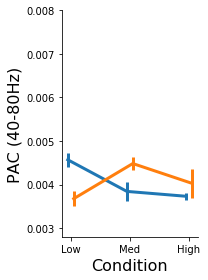

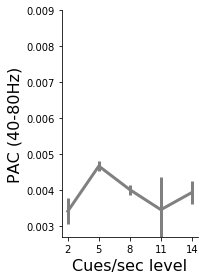

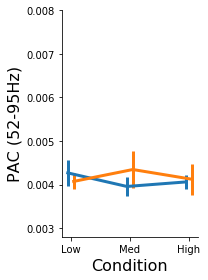

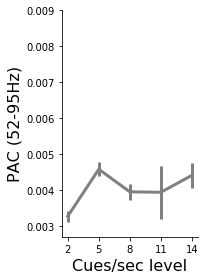

In [120]:
brfreqs = [[8,12],
[12,30],
[30,48],
[40,80],
[52,95]]


save_log_pacs = {}
save_amp_in_phase = {}
count = 0
for ff in range(len(brfreqs)):
    
    l_f_amp,h_f_amp= brfreqs[ff][0], brfreqs[ff][1]

    amp_phase = get_phase_amplitude(l_f_amp,h_f_amp)
    log_pac,log_amp_in_phase = organize_amp_phase_to_pandas(amp_phase)

    plot_pac_speed_density(log_pac,[l_f_amp,h_f_amp])
    plot_pac_cuesec(log_pac,[l_f_amp,h_f_amp])
    
    
    
    save_log_pacs[count] = {}
    save_log_pacs[count]['freqs'] = [l_f_amp,h_f_amp]
    save_log_pacs[count]['log_pac'] = log_pac    
    
    save_amp_in_phase[count] = {}
    save_amp_in_phase[count]['bs'] = log_amp_in_phase
    
    count += 1

#########  P val density #########
p=0.105
###########################
#########  P val speed #########
p=0.039
###########################
#########  P val #########
p=0.159
###########################




---------------------------------------------
Speed
FriedmanchisquareResult(statistic=3.5, pvalue=0.1737739434504451)
              sum_sq     df        F    PR(>F)
kb          5.808023    1.0  8.79638  0.003121
Residual  462.191977  700.0      NaN       NaN




---------------------------------------------
Density
FriedmanchisquareResult(statistic=2.0, pvalue=0.36787944117144245)


              sum_sq     df         F   PR(>F)
kb          0.286444    1.0  0.428704  0.51284
Residual  467.713556  700.0       NaN      NaN




---------------------------------------------
csw
FriedmanchisquareResult(statistic=6.400000000000006, pvalue=0.17120125670913774)
              sum_sq     df         F    PR(>F)
kb          1.038495    1.0  0.807454  0.369183
Residual  900.294839  700.0       N

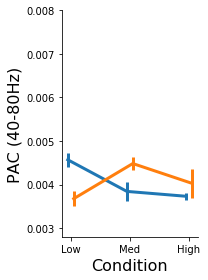

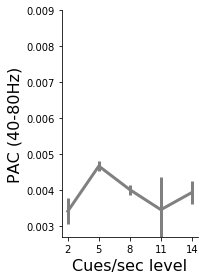

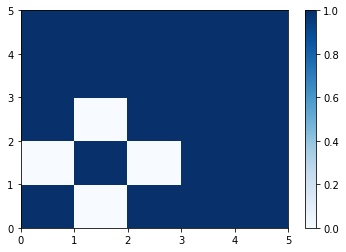

In [124]:

plot_pac_speed_density(save_log_pacs[3]['log_pac'],save_log_pacs[3]['freqs'])
plot_pac_cuesec(save_log_pacs[3]['log_pac'],save_log_pacs[3]['freqs'])

log_df = save_log_pacs[3]['log_pac']

print('\n\n\n')
print('---------------------------------------------')
print('Speed')
mmm = log_df.groupby(['speed','sub']).median()['kb'].unstack()
mmm_np = mmm.to_numpy()
print( stats.friedmanchisquare(  *[mmm_np[ii] for ii in range(mmm_np.shape[0])] ))
cw_lm=ols('speed ~ kb', data=log_df).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

print('\n\n\n')
print('---------------------------------------------')
print('Density')
mmm = log_df.groupby(['density','sub']).median()['kb'].unstack()
mmm_np = mmm.to_numpy()
print( stats.friedmanchisquare(  *[mmm_np[ii] for ii in range(mmm_np.shape[0])] ))
print('\n')
cw_lm=ols('density ~ kb', data=log_df).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))



print('\n\n\n')
print('---------------------------------------------')
print('csw')
mmm = log_df.groupby(['cuesec_w','sub']).median()['kb'].unstack()
mmm_np = mmm.to_numpy()
print( stats.friedmanchisquare(  *[mmm_np[ii] for ii in range(mmm_np.shape[0])] ))
cw_lm=ols('cuesec_w ~ kb', data=log_df).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

print('\n\n\n')


print('Posthoc')

this_pd_np = log_df.to_numpy()

this_pd_np_per_sub_cond = []
for sub in np.unique(this_pd_np[:,0]):
    tmp = []
    for csw in np.unique(this_pd_np[:,4]):        
        idx = np.where(np.logical_and( this_pd_np[:,0]==sub, this_pd_np[:,4]==csw ))[0]
        tmp.append( np.mean(this_pd_np[idx,5]) )
    this_pd_np_per_sub_cond.append(tmp)
this_pd_np_per_sub_cond = np.array(this_pd_np_per_sub_cond)

wc_pval = np.zeros((5,5))
for x in range(5):
    for y in range(5):
        wc_pval[x,y]=stats.mannwhitneyu(this_pd_np_per_sub_cond[:,x],this_pd_np_per_sub_cond[:,y])[1]    

        
wc_pval[wc_pval<=0.1]=0
wc_pval[wc_pval>0.1]=1
plt.figure()
plt.pcolor(wc_pval, cmap='Blues')
plt.colorbar()

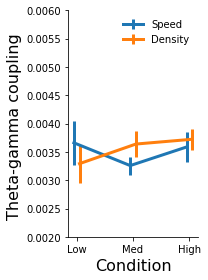

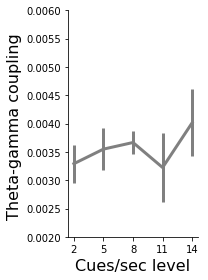

In [797]:
log_pac,log_freqs = save_log_pacs[3]['log_pac'],save_log_pacs[3]['freqs']
var_of_interst = 'kb'

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)
fig.set_facecolor('white')

mmd = log_pac.groupby(['density','sub']).median()[var_of_interst].unstack().T.median()  #log_pac.groupby(['density']).mean()[var_of_interst]
mms = log_pac.groupby(['speed','sub']).median()[var_of_interst].unstack().T.median()  #log_pac.groupby(['speed']).mean()[var_of_interst]
ssd = log_pac.groupby(['density','sub']).median()[var_of_interst].unstack().T.std() #log_pac.groupby(['density']).sem()[var_of_interst]
sss = log_pac.groupby(['speed','sub']).median()[var_of_interst].unstack().T.std() #log_pac.groupby(['speed']).sem()[var_of_interst]

plt.errorbar(  np.arange(3)-0.05, mms, yerr=sss, label='Speed', linewidth=3 )
plt.errorbar(  np.arange(3)+0.05, mmd, yerr=ssd, label='Density', linewidth=3  )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.legend( frameon=False, loc='upper right')
plt.ylabel('Theta-gamma coupling '  , fontsize=16)
plt.xlabel('Condition', fontsize=16)
plt.xticks(range(3), ['Low','Med','High'])
plt.ylim(0.002,0.006)
ym = plt.ylim()[1]*0.95
plt.tight_layout()
plt.savefig('Figures/pac_speed_density.pdf')







mmcs = log_pac.groupby(['cuesec_w','sub']).median()[var_of_interst].unstack().T.median()  #log_pac.groupby(['density']).mean()[var_of_interst]
sscs = log_pac.groupby(['cuesec_w','sub']).median()[var_of_interst].unstack().T.std() #log_pac.groupby(['density']).sem()[var_of_interst]

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)
fig.set_facecolor('white')


plt.ylim(0.002,0.006)


ax.errorbar(  range(mmcs.size), mmcs, yerr=sscs, linewidth=3, label=pval_str, color=plo['cuesec_color'] )

fig.patch.set_facecolor('xkcd:white')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.ylabel('Theta-gamma coupling '  , fontsize=16)
plt.xlabel('Cues/sec level', fontsize=16)

plt.xticks(np.arange(mmcs.size), np.linspace(2,14,mmcs.size).astype(int) );

plt.tight_layout()
plt.savefig('Figures/pac_cuesec.pdf')



## Distribution of Gamma-amplitude in Theta-phase

<li> Compute where in the theta cycle does gamma amplitude seats, depending on cue/sec condition.</li>
<ol>
    <li> Get the gamma amplitude distribution along the theta cycle.  
    <li> Find the peaks of gamma in phase.
    <li> Compute the 
</ol>
    


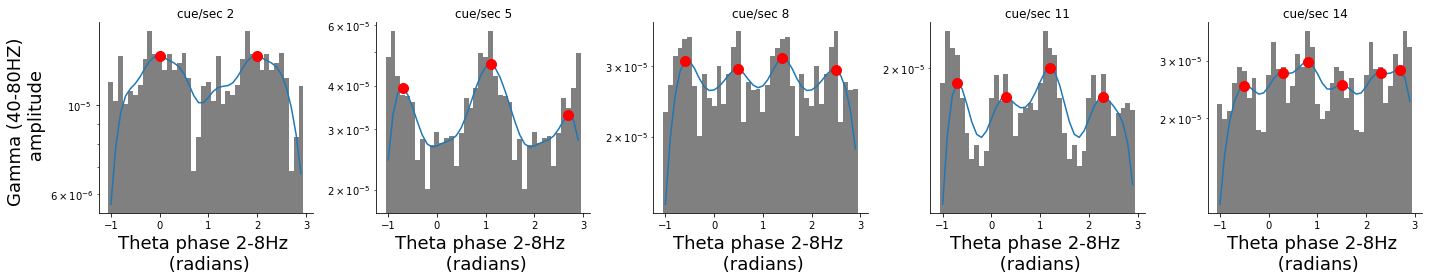

In [126]:
fig , ax = plt.subplots(1,5)
fig.set_figheight(4)
fig.set_figwidth(20)
fig.set_facecolor('white')

pcount = 0
# for ii in [ 80, 60, 39]:
for ii in [ 135, 12, 60, 142, 80]:

    bbss = save_amp_in_phase[3]['bs'][ii]
    phase_rad = np.concatenate([bbss[1][:-1]/np.pi, (bbss[1][:-1] + np.pi*2)/np.pi ]) 
    pac_dist  = np.concatenate([bbss[0],bbss[0]]) 
    pac_dist_smooth = smooth_psd(pac_dist, sz=40, sigma=2)
    peak_pac_dist = scipy.signal.find_peaks(pac_dist_smooth)[0]

    plt.sca(ax[pcount])
    plt.yscale('log')
    plt.bar(  bbss[1][:-1]/np.pi , bbss[0] , width=0.1, color='grey' )
    plt.bar(  (bbss[1][:-1] + np.pi*2)/np.pi , bbss[0] , width=0.1, color='grey' )
#     plt.plot(phase_rad, pac_dist)
    plt.plot(phase_rad, pac_dist_smooth)
    plt.plot(phase_rad[peak_pac_dist], pac_dist_smooth[peak_pac_dist], 'ro', markersize=10)
    plt.title( 'cue/sec ' + str(int(np.linspace(2,14,5)[pcount]))  )
    if pcount ==0: plt.ylabel('Gamma (40-80HZ) \n amplitude', fontsize=18)
    plt.xlabel('Theta phase 2-8Hz \n (radians)', fontsize=18)

    
    ax[pcount].spines['right'].set_visible(False)
    ax[pcount].spines['top'].set_visible(False)

    
    pcount+=1
    
plt.tight_layout()

In [1451]:
### Save the number of peaks in each PAC distribution (phase theta ,  amplitude 40-80Hz )
peaks_pac_distance = []
peaks_pac_count = []
peaks_pac_dist = []
for ii in range(len(save_amp_in_phase[3]['bs'])):  ## 3 because brfreqs[3] == [40,80]
    bbss = save_amp_in_phase[3]['bs'][ii]
    phase_rad = np.concatenate([bbss[1][:-1]/np.pi, (bbss[1][:-1] + np.pi*2)/np.pi ])
    pac_dist  = np.concatenate([bbss[0],bbss[0]])

    pac_dist_smooth = smooth_psd(pac_dist, sz=40, sigma=2)
    peak_pac_dist = scipy.signal.find_peaks(pac_dist_smooth)[0]
    peaks_pac_dist.append( phase_rad[peak_pac_dist] )
    peaks_pac_count.append( peak_pac_dist.size )
    peaks_pac_distance.append(  np.diff(peak_pac_dist[:int(peak_pac_dist.size/2)] ) )

peaks_pac_dist = np.array(peaks_pac_dist)
peaks_pac_count = np.array(peaks_pac_count)
peaks_pac_distance = np.array(peaks_pac_distance)

In [1452]:
# sub	density	speed	cuesec	cuesec_w	kb	n_pac_peaks

band_id = 3
lfreq, hfreq = save_log_pacs[band_id]['freqs']

save_log_pacs_np = np.copy(save_log_pacs[band_id]['log_pac'].to_numpy())
condition_coherence = []

for sub in np.unique(save_log_pacs_np[:,0]):
    tmp = []
    for csw in np.unique(save_log_pacs_np[:,4]):
        idx = np.where( np.logical_and( save_log_pacs_np[:,0]==sub, save_log_pacs_np[:,4]==csw   ) )[0]
        tmp.append( get_ITPC( np.concatenate(peaks_pac_dist[idx]) ) )
#         tmp.append( np.mean(peaks_pac_count[idx]) )
#         tmp.append( np.mean(np.concatenate(peaks_pac_distance[idx])) )
        
        
    condition_coherence.append(tmp)
condition_coherence = np.array(condition_coherence)

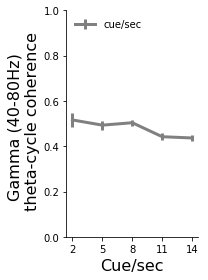

In [1454]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)
fig.set_facecolor('white')

mmm = np.median(condition_coherence,axis=0)
sss = stats.sem(condition_coherence,axis=0)
# sss = statsmodels.robust.scale.mad(condition_coherence,axis=0)

# for sub in range(4):
#     plt.plot(np.linspace(2,14,mmm.size) , condition_coherence[sub], color='C9', alpha=0.3)
plt.errorbar(  np.linspace(2,14,mmm.size), mmm, yerr=sss, label='cue/sec', linewidth=3,color=plo['cuesec_color'] )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.legend( frameon=False, loc='upper left')
plt.xlabel('Cue/sec', fontsize=16)
plt.ylabel('Gamma ('+str(lfreq)+'-'+str(hfreq) +'Hz) \n theta-cycle coherence', fontsize=16)
plt.xticks(  np.linspace(2,14,mmm.size).astype(int) );

plt.ylim(0,1)

plt.tight_layout()
plt.savefig('Figures/gamma_amp_in_theta_cycle_coherence.pdf')

In [133]:
pcounter = 1
# plt.figure(figsize=(13,5))
pac_peak_count = []
for sub in np.unique(save_log_pacs_np[:,0]):
    tmp_sub = []
    for csw in np.unique(save_log_pacs_np[:,4]):
        
        
        idx = np.logical_and( save_log_pacs_np[:,0] == sub,  save_log_pacs_np[:,4] == csw )
        tmp_h = peaks_pac_count[idx]
        tmp_xx = np.arange(1,8)
        tmp_yy = [np.where( tmp_h == ii )[0].size  for ii in tmp_xx ]
        tmp_sub.append(tmp_yy)
        
    pac_peak_count.append(tmp_sub)
    
pac_peak_count = np.array(pac_peak_count)

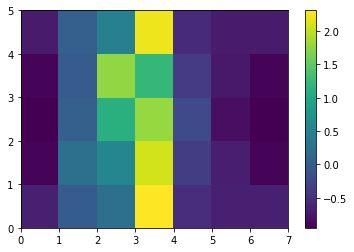

In [134]:
n_cycles = np.median(pac_peak_count,axis=0)
n_cycles = stats.zscore(n_cycles,axis=1)
fig = plt.figure()
fig.set_facecolor('white')
plt.pcolor( n_cycles )
plt.colorbar()





---------------------------------------------
csw
FriedmanchisquareResult(statistic=1.1249999999999982, pvalue=0.7710426682428909)




Posthoc


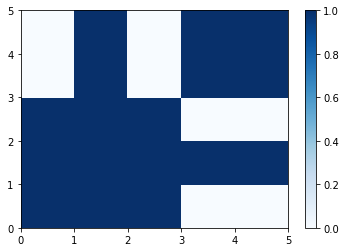

In [184]:



print('\n\n\n')
print('---------------------------------------------')
print('csw')

print( stats.friedmanchisquare(  *[condition_coherence[ii] for ii in range(condition_coherence.shape[0])] ))
print('\n\n\n')


print('Posthoc')

wc_pval = np.zeros((5,5))
for x in range(5):
    for y in range(5):
        wc_pval[x,y]=stats.mannwhitneyu(condition_coherence[:,x],condition_coherence[:,y])[1]    

        
wc_pval[wc_pval<=0.1]=0
wc_pval[wc_pval>0.1]=1
plt.figure()
plt.pcolor(wc_pval, cmap='Blues')
plt.colorbar()

In [145]:
def plot_pac_examples(amp_phase):

    sub = 2
    cc = 0

    tmp_tmp_phase = amp_phase[sub]['phase'][cc]
    tmp_tmp_amp = amp_phase[sub]['amp'][cc]
    bs = binned_statistic(tmp_tmp_phase,tmp_tmp_amp,bins=20)
    kb = calculate_KB(bs)

    fig = plt.figure()
    fig.set_figheight(3)
    fig.set_figwidth(4)
    ax = fig.add_subplot(111)

    plt.bar(  bs[1][:-1]/np.pi , bs[0] , width=0.1, color='grey' )
    plt.bar(  (bs[1][:-1] + np.pi*2)/np.pi , bs[0] , width=0.1, color='grey' )
    # ax.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g $\pi$'))
    # plt.xticks(fontsize=14)
    # plt.yticks(fontsize=14)


    # plt.ylim(0.00001,0.00007)
    # plt.title(  'sub: ' + str(amp_phase[sub]['info'][0]) )
    # plt.show()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title(np.round(kb,6))
    plt.sca(ax)

    plt.ylabel('Amplitude ' + str(l_f_amp)+'-'+str(h_f_amp)+'Hz (mV)', fontsize=14)
    plt.xlabel('Theta phase 2-8Hz (radians)', fontsize=14)

    # fig.text(0.5, -0.04, '2-8Hz Theta phase (radians)', ha='center', fontsize=16)
    # fig.text(-0.01, 0.5, '20-48Hz Amplitude (mV)', va='center', rotation='vertical', fontsize=16)

    fig.patch.set_facecolor('xkcd:white')
    plt.tight_layout()

    plt.show()

Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  1
Channel:  19 B'1
Channel:  20 B'2
Channel:  29 C'1
Channel:  30 C'2
Sub:  1
Channel:  19 B'1
Channel:  20 B'2
Channel:  29 C'1
Channel:  30 C'2
Sub:  3
Channel:  7 B'1
Channel:  8 B'2
Channel:  15 C'1
Channel:  16 C'2
Sub:  4
Channel:  22 C'1
Channel:  23 C'2


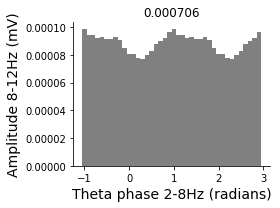

Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  1
Channel:  19 B'1
Channel:  20 B'2
Channel:  29 C'1
Channel:  30 C'2
Sub:  1
Channel:  19 B'1
Channel:  20 B'2
Channel:  29 C'1
Channel:  30 C'2
Sub:  3
Channel:  7 B'1
Channel:  8 B'2
Channel:  15 C'1
Channel:  16 C'2
Sub:  4
Channel:  22 C'1
Channel:  23 C'2


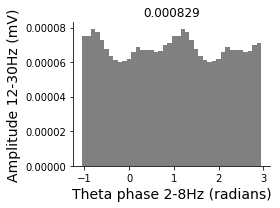

Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  1
Channel:  19 B'1
Channel:  20 B'2
Channel:  29 C'1
Channel:  30 C'2
Sub:  1
Channel:  19 B'1
Channel:  20 B'2
Channel:  29 C'1
Channel:  30 C'2
Sub:  3
Channel:  7 B'1
Channel:  8 B'2
Channel:  15 C'1
Channel:  16 C'2
Sub:  4
Channel:  22 C'1
Channel:  23 C'2


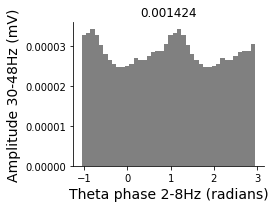

Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  1
Channel:  19 B'1
Channel:  20 B'2
Channel:  29 C'1
Channel:  30 C'2
Sub:  1
Channel:  19 B'1
Channel:  20 B'2
Channel:  29 C'1
Channel:  30 C'2
Sub:  3
Channel:  7 B'1
Channel:  8 B'2
Channel:  15 C'1
Channel:  16 C'2
Sub:  4
Channel:  22 C'1
Channel:  23 C'2


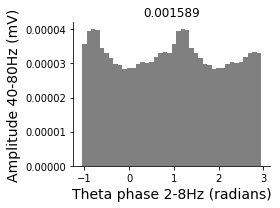

Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  0
Channel:  47 B1
Channel:  48 B2
Channel:  55 C1
Channel:  56 C2
Sub:  1
Channel:  19 B'1
Channel:  20 B'2
Channel:  29 C'1
Channel:  30 C'2
Sub:  1
Channel:  19 B'1
Channel:  20 B'2
Channel:  29 C'1
Channel:  30 C'2
Sub:  3
Channel:  7 B'1
Channel:  8 B'2
Channel:  15 C'1
Channel:  16 C'2
Sub:  4
Channel:  22 C'1
Channel:  23 C'2


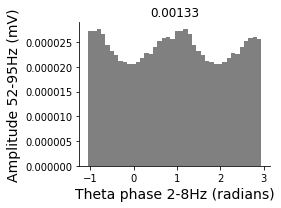

In [146]:
brfreqs = [[8,12],
[12,30],
[30,48],
[40,80],
[52,95]]


for ff in range(len(brfreqs)):
    l_f_amp,h_f_amp= brfreqs[ff][0], brfreqs[ff][1]
    amp_phase = get_phase_amplitude(l_f_amp,h_f_amp)
    plot_pac_examples(amp_phase)

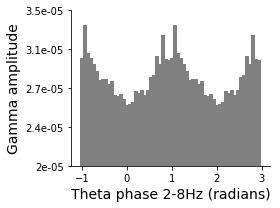

In [838]:

l_f_amp,h_f_amp= 40,80
# amp_phase = get_phase_amplitude(l_f_amp,h_f_amp)




sub = 0
cc = 0

tmp_tmp_phase = amp_phase[sub]['phase'][cc]
tmp_tmp_amp = amp_phase[sub]['amp'][cc]
bs = binned_statistic(tmp_tmp_phase,tmp_tmp_amp,bins=30)
kb = calculate_KB(bs)

fig = plt.figure()
fig.set_figheight(3)
fig.set_figwidth(4)
ax = fig.add_subplot(111)

plt.bar(  bs[1][:-1]/np.pi , bs[0] , width=0.1, color='grey' )
plt.bar(  (bs[1][:-1] + np.pi*2)/np.pi , bs[0] , width=0.1, color='grey' )



plt.ylim(0.00002,0.000035)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.sca(ax)

plt.ylabel('Gamma amplitude', fontsize=14)
plt.xlabel('Theta phase 2-8Hz (radians)', fontsize=14)

plt.yticks(np.linspace(0.00002,0.000035,5),np.round(np.linspace(0.00002,0.000035,5),6))

fig.patch.set_facecolor('xkcd:white')


plt.tight_layout()
plt.savefig('Figures/theta_gamma_distribution_example.pdf')


In [815]:
np.linspace(0.00002,0.000043,5)

array([2.000e-05, 2.575e-05, 3.150e-05, 3.725e-05, 4.300e-05])

In [619]:
freq_labels = []
pac_vars = []
for ii in save_log_pacs:
    if ii>0:
        mm = save_log_pacs[ii]['log_pac'].groupby('sub')['kb'].var().mean()
        ss = save_log_pacs[ii]['log_pac'].groupby('sub')['kb'].var().sem()
        pac_vars.append( [mm,ss] )

        fl,fh = save_log_pacs[ii]['freqs']
        freq_labels.append( str(fl) +'-'+str(fh))

pac_vars = np.array(pac_vars)

(-0.5, 2.5)

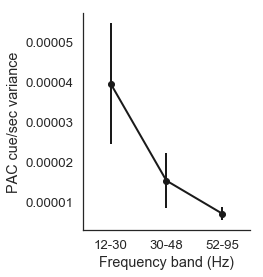

In [621]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)
sns.set(font_scale=1.2, style='white')
plt.errorbar( np.arange(pac_vars.shape[0]), pac_vars[:,0], yerr=pac_vars[:,1], color='k', linewidth=2, marker='o')
plt.xticks(  np.arange(len(freq_labels)), freq_labels );
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Frequency band (Hz)')
plt.ylabel('PAC cue/sec variance')
plt.xlim(-.5,2.5)

# P-episodes in gamma

In [1441]:
low_amp_freq = 40
high_amp_freq = 80


phase_of_p_episodes = []  # save theta phase of each P-episode
log_p_episodes = []
for ii in ttl_info_dict:

    filename = 'data/sub_'+str(ttl_info_dict[ii]['subject'])+'_session_'+str(ttl_info_dict[ii]['session'])+'_raw.fif'
        
    raw = mne.io.read_raw_fif(filename, preload=True, verbose=False)
    trials = ttl_info_dict[ii]['markers']
    
    
    if trials.size == 27:

        print('Sub: ' , ttl_info_dict[ii]['subject'] )
        for cc in range(len(ttl_info_dict[ii]['hpc_channels_idx'])):


            ch_indx = ttl_info_dict[ii]['hpc_channels_idx'][cc]
            ch_name = ttl_info_dict[ii]['hpc_channels_name'][cc]


            print('Channel: ', ch_indx, ch_name )

            raw_copy = raw.copy().pick_channels([ch_name])
            raw_copy.notch_filter([50.,100.,150.,200.],notch_widths=.1,verbose=False)

            tmp_lfp = raw_copy.get_data()[0]


            freqs = np.logspace(*np.log10([low_amp_freq,high_amp_freq]), num=20)
            n_cycles = freqs / 2.  # different number of cycle per frequency
            power = mne.time_frequency.tfr_array_morlet([[tmp_lfp]],raw.info['sfreq'], freqs=freqs, n_cycles=n_cycles, use_fft=True,
                                                  output='power',decim=1, n_jobs=1,verbose=False)
            power = power[0,0]

#             power_zs = stats.zscore(power,axis=0)
#             power_zs[power_zs>=2.] = 2
#             power_zs[power_zs<2.] = 0

            theta_phase = hilbert_transform_get_component(tmp_lfp, raw.info['sfreq'], 2,8, 'phase')
#             percentile_95 = np.percentile(power[:,4000:-2000],95,axis=1)
            percentile_95 = np.percentile(power[:,4000:-4000],97,axis=1)  ## 26_3_19_16_08
    
            tmp_phase_of_p_episodes = []
            for trial_n in range(len(trials)):
                
                total_pepi_counts_in_this_trial = 0
                for fff in range(len(freqs)):
                    cycle_threshold = 3 # minimunm of 3 cycles to be considered a P-episode
                    time_threshold  = int(raw.info['sfreq'] / freqs[fff] * cycle_threshold)
#                     power_zs_conv =  np.convolve(power_zs[fff], np.ones((time_threshold,))/time_threshold, mode='same')
#                     power_zs_conv[power_zs_conv<2.] = 0
                    
                    bina_pow = np.copy(power[fff])
                    bina_pow[bina_pow<=percentile_95[fff]] = 0

                    bina_pow_conv =  np.convolve(bina_pow, np.ones((time_threshold,))/time_threshold, mode='same')
                    
                    p_episode_idx = np.where( bina_pow_conv > 0 )[0]
                    list_of_P_episodes = np.where( np.logical_and(  p_episode_idx > trials[trial_n] , p_episode_idx < trials[trial_n]+(raw.info['sfreq']*3)   ) )[0]
                    counts = list_of_P_episodes.size
                    total_pepi_counts_in_this_trial += counts
                    tmp_phase_of_p_episodes.append(   theta_phase[list_of_P_episodes] )
                    
                cs = unii[trial_n]#  dd[density[trial_n]]/dur[speed[trial_n]]
                csw = np.argmin(np.abs(cs-np.linspace(2,14,5)))
                log_p_episodes.append( [ttl_info_dict[ii]['subject'], density[trial_n], speed[trial_n], cs, csw, total_pepi_counts_in_this_trial] )
                phase_of_p_episodes.append(  np.concatenate(tmp_phase_of_p_episodes)  )

log_p_episodes = pd.DataFrame(log_p_episodes, columns=['sub','density','speed','cuesec','cuesec_w','p_epi_counts'] )
phase_of_p_episodes = np.array(phase_of_p_episodes)

Sub:  0
Channel:  47 B1
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Channel:  48 B2
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Channel:  55 C1
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Channel:  56 C2
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Sub:  0
Channel:  47 B1
Creating RawArray with float64 data, n_channels=1, n_times=210001
    Range : 0 ... 210000 =      0.000 ...   420.000 secs
Ready.
Channel:  48 B2
Creating RawArray with float64 data, n_channels=1, n_times=210001
    Range : 0 ... 210000 =      0.000 ...   420.000 secs
Ready.
Channel:  55 C1
Creating RawArray with float64 data, n_channels=1, n_times=210001
    Range : 0 ... 210000 =

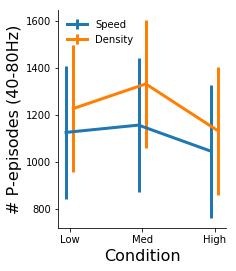

In [1442]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)
fig.set_facecolor('white')
# sns.set(font_scale=1.2, style='white')

mmm = log_p_episodes.groupby(['speed','sub']).median()['p_epi_counts'].unstack().T.median()
sss = log_p_episodes.groupby(['speed','sub']).median()['p_epi_counts'].unstack().T.values.std()  #log_p_episodes.groupby(['speed','sub']).mean()['p_epi_counts'].unstack().T.std()
plt.errorbar(  np.arange(3)-0.05, mmm, yerr=sss, label='Speed', linewidth=3, color=plo['speed_color'] )

mmm = log_p_episodes.groupby(['density','sub']).mean()['p_epi_counts'].unstack().T.mean()
sss = log_p_episodes.groupby(['density','sub']).mean()['p_epi_counts'].unstack().T.values.std()  #log_p_episodes.groupby(['density','sub']).mean()['p_epi_counts'].unstack().T.std()
plt.errorbar(  np.arange(3)+0.05, mmm, yerr=sss, label='Density', linewidth=3, color=plo['density_color'] )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.legend( frameon=False, loc='upper left')
plt.xlabel('Condition', fontsize=16)
plt.ylabel('# P-episodes (' +str(low_amp_freq)+'-'+str(high_amp_freq)+'Hz)'     , fontsize=16)
plt.xticks(range(3), ['Low','Med','High']);

# plt.ylim(38.7,39.2)

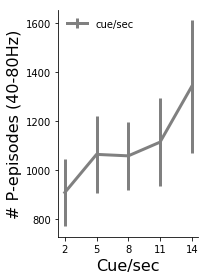

In [1443]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)
fig.set_facecolor('white')
# sns.set(font_scale=1.2, style='white')

# mmm = log_p_episodes.groupby(['cuesec_w','sub']).mean()['p_epi_counts'].unstack().T.median()
# sss = log_p_episodes.groupby(['cuesec_w','sub']).mean()['p_epi_counts'].unstack().T.values.std() #log_p_episodes.groupby(['cuesec_w','sub']).mean()['p_epi_counts'].unstack().T.std()

mmm = np.median(log_p_episodes.groupby(['cuesec_w','sub']).median()['p_epi_counts'].unstack().T.values,axis=0)
sss = stats.sem(log_p_episodes.groupby(['cuesec_w','sub']).median()['p_epi_counts'].unstack().T.values,axis=0)
# sss = statsmodels.robust.scale.mad(log_p_episodes.groupby(['cuesec_w','sub']).median()['p_epi_counts'].unstack().T.values)

plt.errorbar(  np.linspace(2,14,mmm.size), mmm, yerr=sss, label='cue/sec', linewidth=3, color=plo['cuesec_color'] )



ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.legend( frameon=False, loc='upper left')
plt.xlabel('Cue/sec', fontsize=16)
plt.ylabel('# P-episodes (' +str(low_amp_freq)+'-'+str(high_amp_freq)+'Hz)'     , fontsize=16)
# plt.xticks(range(3), ['Low','Med','High']);
# plt.xticks(np.arange(mmm.size), np.linspace(2,14,mmm.size).astype(int) );
plt.xticks( np.linspace(2,14,mmm.size).astype(int) );
# plt.ylim(38.7,39.2)


plt.tight_layout()
# plt.savefig('Figures/P_episodes_count_cuesec.pdf')



In [891]:
pptmp = log_p_episodes.groupby(['cuesec_w','sub']).median()['p_epi_counts'].unstack().values
stats.ttest_ind(pptmp[:,:2].flatten() , pptmp[:,-2:].flatten())

Ttest_indResult(statistic=3.1130729358123315, pvalue=0.006005058913145823)





---------------------------------------------
Speed
FriedmanchisquareResult(statistic=2.0, pvalue=0.36787944117144245)
                  sum_sq     df         F    PR(>F)
p_epi_counts    1.359975    1.0  2.040078  0.153648
Residual      466.640025  700.0       NaN       NaN




---------------------------------------------
Density
FriedmanchisquareResult(statistic=1.5, pvalue=0.4723665527410149)


                  sum_sq     df         F   PR(>F)
p_epi_counts    0.568778    1.0  0.851772  0.35637
Residual      467.431222  700.0       NaN      NaN




---------------------------------------------
csw
FriedmanchisquareResult(statistic=3.200000000000003, pvalue=0.5249309467861037)
                  sum_sq     df        F    PR(>F)
p_epi_counts    0.559329    1.0  0.43466  0.509928
Residual      900.774005  700.0      NaN       NaN




Posthoc


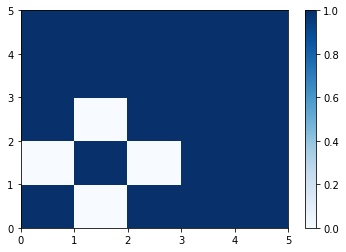

In [152]:
log_df = log_p_episodes

print('\n\n\n')
print('---------------------------------------------')
print('Speed')
mmm = log_df.groupby(['speed','sub']).median()['p_epi_counts'].unstack()
mmm_np = mmm.to_numpy()
print( stats.friedmanchisquare(  *[mmm_np[ii] for ii in range(mmm_np.shape[0])] ))
cw_lm=ols('speed ~ p_epi_counts', data=log_df).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

print('\n\n\n')
print('---------------------------------------------')
print('Density')
mmm = log_df.groupby(['density','sub']).median()['p_epi_counts'].unstack()
mmm_np = mmm.to_numpy()
print( stats.friedmanchisquare(  *[mmm_np[ii] for ii in range(mmm_np.shape[0])] ))
print('\n')
cw_lm=ols('density ~ p_epi_counts', data=log_df).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))



print('\n\n\n')
print('---------------------------------------------')
print('csw')
mmm = log_df.groupby(['cuesec_w','sub']).median()['p_epi_counts'].unstack()
mmm_np = mmm.to_numpy()
print( stats.friedmanchisquare(  *[mmm_np[ii] for ii in range(mmm_np.shape[0])] ))
cw_lm=ols('cuesec_w ~ p_epi_counts', data=log_df).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

print('\n\n\n')


print('Posthoc')

this_pd_np = log_df.to_numpy()

this_pd_np_per_sub_cond = []
for sub in np.unique(this_pd_np[:,0]):
    tmp = []
    for csw in np.unique(this_pd_np[:,4]):        
        idx = np.where(np.logical_and( this_pd_np[:,0]==sub, this_pd_np[:,4]==csw ))[0]
        tmp.append( np.mean(this_pd_np[idx,5]) )
    this_pd_np_per_sub_cond.append(tmp)
this_pd_np_per_sub_cond = np.array(this_pd_np_per_sub_cond)

wc_pval = np.zeros((5,5))
for x in range(5):
    for y in range(5):
        wc_pval[x,y]=stats.mannwhitneyu(this_pd_np_per_sub_cond[:,x],this_pd_np_per_sub_cond[:,y])[1]    

        
wc_pval[wc_pval<=0.1]=0
wc_pval[wc_pval>0.1]=1
plt.figure()
plt.pcolor(wc_pval, cmap='Blues')
plt.colorbar()

In [1444]:
### Save the number of peaks in each PAC distribution (phase theta ,  amplitude 40-80Hz )
peaks_pepi_distance = []
peaks_pepi_count = []
peaks_pepi_dist = []
for ii in range(len(phase_of_p_episodes)):

    bbss = np.histogram(phase_of_p_episodes[ii],bins=20)
    phase_rad = np.concatenate([bbss[1][:-1]/np.pi, (bbss[1][:-1] + np.pi*2)/np.pi ]) 
    pepi_dist  = np.concatenate([bbss[0],bbss[0]])
    pepi_dist_smooth = smooth_psd(pepi_dist, sz=40, sigma=2)
    peak_pepi_dist = scipy.signal.find_peaks(pepi_dist_smooth)[0]
    peaks_pepi_dist.append( phase_rad[peak_pepi_dist] )
    peaks_pepi_count.append( peak_pepi_dist.size )
    peaks_pepi_distance.append(  np.diff(peak_pepi_dist[:int(peak_pepi_dist.size/2)] ) )
    
    
peaks_pepi_dist = np.array(peaks_pepi_dist)
peaks_pepi_count = np.array(peaks_pepi_count)
peaks_pepi_distance = np.array(peaks_pepi_distance)

In [1445]:
# sub	density	speed	cuesec	cuesec_w	kb	n_pac_peaks

save_log_pacs_np = np.copy(save_log_pacs[3]['log_pac'].to_numpy())

condition_coherence = []

for sub in np.unique(save_log_pacs_np[:,0]):
    tmp = []
    for csw in np.unique(save_log_pacs_np[:,4]):
        idx = np.where( np.logical_and( save_log_pacs_np[:,0]==sub, save_log_pacs_np[:,4]==csw   ) )[0]
        tmp.append( get_ITPC( np.concatenate(peaks_pepi_dist[idx]) ) )
#         tmp.append( np.mean(peaks_pac_count[idx]) )
#         tmp.append( np.mean(np.concatenate(peaks_pac_distance[idx])) )
        
        
    condition_coherence.append(tmp)
condition_coherence = np.array(condition_coherence)

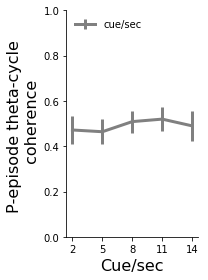

In [1450]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)
fig.set_facecolor('white')

mmm = np.median(condition_coherence,axis=0)
sss = stats.sem(condition_coherence,axis=0)

plt.errorbar(  np.linspace(2,14,mmm.size), mmm, yerr=sss, label='cue/sec', linewidth=3,color=plo['cuesec_color'] )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.legend( frameon=False, loc='upper left')
plt.xlabel('Cue/sec', fontsize=16)
plt.ylabel('P-episode theta-cycle \n coherence', fontsize=16)
plt.xticks(  np.linspace(2,14,mmm.size).astype(int) );

plt.ylim(0,1)


plt.tight_layout()
plt.savefig('Figures/P_episodes_coherence_in_theta_phase_cuesec.pdf')


In [846]:
log_p_episodes_np = log_p_episodes.to_numpy()

all_sub_pepi_mean_in_theta_quadrant = []
for sub in np.unique(log_p_episodes_np[:,0]):
    
    sub_pepi_mean_in_theta_quadrant = []
    for csw in np.unique(log_p_episodes_np[:,4]):
        
        idx = np.where(np.logical_and( log_p_episodes_np[:,0]==sub, log_p_episodes_np[:,4]==csw  ))[0]

        csw_pepi_mean_in_theta_quadrant = []
        for trial in idx:
            tmp_hist = np.histogram(phase_of_p_episodes[trial],bins=20)
            y = tmp_hist[0]
            tmp_pepi_mean_in_theta_quadrant = np.median(y.reshape(4,5),axis=1)                    
            csw_pepi_mean_in_theta_quadrant.append(tmp_pepi_mean_in_theta_quadrant)

        sub_pepi_mean_in_theta_quadrant.append(  np.median(csw_pepi_mean_in_theta_quadrant,axis=0) )

    all_sub_pepi_mean_in_theta_quadrant.append(sub_pepi_mean_in_theta_quadrant)

all_sub_pepi_mean_in_theta_quadrant = np.array(all_sub_pepi_mean_in_theta_quadrant)

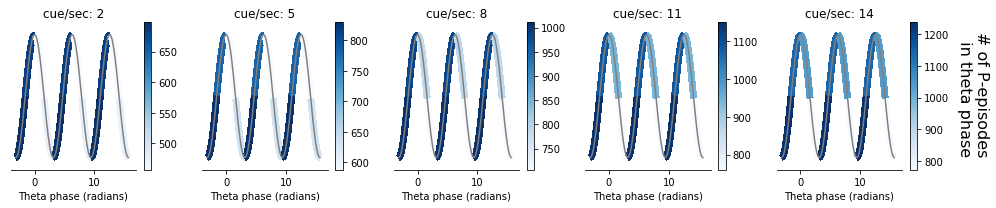

In [852]:
cycle_quadrant_p_epi = np.median(all_sub_pepi_mean_in_theta_quadrant, axis=2)


fig = plt.figure()
fig.set_figheight(3)
fig.set_figwidth(14)
fig.set_facecolor('white')


for csw_cond in range(5):

    this_cq_normalized = np.copy(cycle_quadrant_p_epi[:,csw_cond])
#     this_cq_normalized -= this_cq_normalized.min()
#     this_cq_normalized = this_cq_normalized / this_cq_normalized.max()

    sizee = 100
    x = np.linspace(-np.pi,np.pi,sizee)
    y = np.cos(x)
    t = np.repeat(this_cq_normalized, sizee/4)

    x = np.concatenate([x,x+x.max()*2,x+x.max()*4])
    y = np.tile(y,3)
    t = np.tile(t,3)


    points = np.array([x,y]).transpose().reshape(-1,1,2)
    segs = np.concatenate([points[:-1],points[1:]],axis=1)    
    lc = LineCollection(segs, cmap='Blues', linewidth=6, antialiaseds=False) # make the collection of segments
    lc.set_array(t) # color the segments by our parameter
    
    
    ax = fig.add_subplot(1,5,csw_cond+1)
    plt.plot(x,y, color='Grey')
    plt.gca().add_collection(lc) # add the collection to the plot


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.yticks([])
    ax.spines['left'].set_visible(False)

        
    plt.xlim(-4,17)
    plt.ylim(-1.2,1.2)
    plt.xlabel('Theta phase (radians)')
    plt.title('cue/sec: '+  str(int(np.linspace(2,14,5)[csw_cond])) )
    cbar = fig.colorbar(lc)
#     cbar.set_clim(400,1250)

cbar.set_label('# of P-episodes \n in theta phase', rotation=270, labelpad=40, fontsize=16)



plt.tight_layout()
plt.savefig('Figures/P_episodes_number_in_theta_phase_cuesec.pdf')


<Figure size 1000x1000 with 0 Axes>

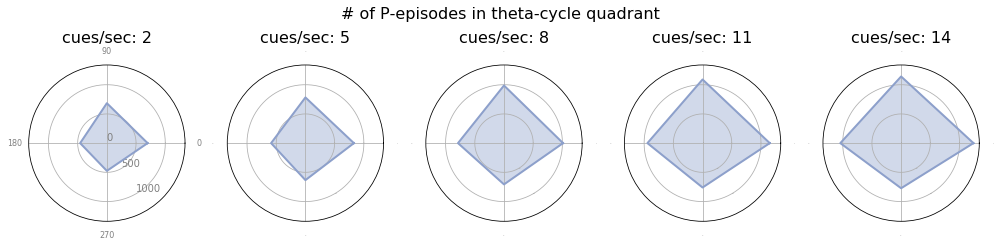

In [854]:
# cycle_quadrant_p_epi

from math import pi
 
# Set data
df = pd.DataFrame({
'group': ['2','5','8','11','14'],
'0': cycle_quadrant_p_epi[0,:],
'90': cycle_quadrant_p_epi[1,:],
'180': cycle_quadrant_p_epi[2,:],
'270': cycle_quadrant_p_epi[3,:],
})
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider( row, title, color):
    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
#     plt.figure(figsize=(18,4))
    ax = plt.subplot(1,5,row+1, polar=True, )

    # If you want the first axis to be on top:
#     ax.set_theta_offset(pi / 2)
#     ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(300)
    
    plt.ylim(cycle_quadrant_p_epi.min(),cycle_quadrant_p_epi.max()+100)

    plt.yticks(  np.linspace(0,1000,3), color='grey', fontsize=10 )
    
    plt.xticks()
    if row !=0:
        plt.xticks( fontsize=0 )
        plt.yticks( fontsize=0 )
    
    
    # Ind1
    values=df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)


    # Add a title
    plt.title(title, size=16, color='k', y=1.1)

# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))

# Loop to plot
fig = plt.figure(figsize=(14,3))
fig.set_facecolor('white')
plt.suptitle('# of P-episodes in theta-cycle quadrant', fontsize=16, y=1.1)
for row in range(0, len(df.index)):
    make_spider( row=row, title='cues/sec: '+df['group'][row], color=my_palette(1))   #color=my_palette(row))


plt.tight_layout()
plt.savefig('Figures/P_episodes_number_in_theta_phase_cuesec_spider.pdf')


### Number of P-episodes along theta phase

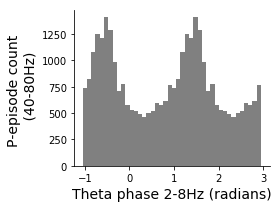

In [856]:
fig = plt.figure()
fig.set_figheight(3)
fig.set_figwidth(4)
ax = fig.add_subplot(111)



bs = np.histogram(phase_of_p_episodes[90], bins=21)

plt.bar(  bs[1][:-1]/np.pi , bs[0] , width=0.1, color='grey' )
plt.bar(  (bs[1][:-1] + np.pi*2)/np.pi , bs[0] , width=0.1, color='grey' )
# plt.hist(phase_of_p_episodes[90], bins=21, color='Grey')


plt.ylabel('Number of P-episodes', fontsize=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.ylabel('P-episode count \n (40-80Hz)', fontsize=14)
plt.xlabel('Theta phase 2-8Hz (radians)', fontsize=14)
fig.patch.set_facecolor('xkcd:white')
plt.tight_layout()


plt.tight_layout()
plt.savefig('Figures/P_episodes_distribution_example.pdf')




In [931]:
max_p_epi = []
for ii in range(len(phase_of_p_episodes)):
    pepi_hist = np.histogram(phase_of_p_episodes[ii], bins=20)
    xxx = np.copy(pepi_hist[1][:-1])
#     xxx = np.concatenate((xxx,xxx+(np.pi*2)))  #pepi_hist[1][:-1]
    hist_pepi =  pepi_hist[0] # np.tile(pepi_hist[0],2)
    
    pepi_dist_smooth = smooth_psd(hist_pepi, sz=20, sigma=2)
    peak_pepi_dist = scipy.signal.find_peaks(pepi_dist_smooth)[0]
    
    
    
    tmp_max_of_pepi = xxx[ peak_pepi_dist[ np.argmax(pepi_dist_smooth[peak_pepi_dist])]]
    max_p_epi.append( tmp_max_of_pepi )
max_p_epi = np.array(max_p_epi)

(-3.141592653589793, 3.141592653589793)

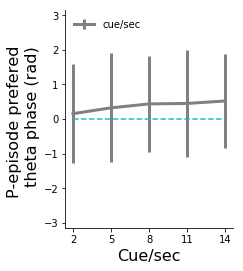

In [943]:
pepi_maxs = []
for sub in np.unique(save_log_pacs_np[:,0]):
    tmp_sub = []
    for csw in np.unique(save_log_pacs_np[:,4]):
        idx = np.logical_and( save_log_pacs_np[:,0] == sub,  save_log_pacs_np[:,4] == csw )        
        tmp_sub.append( np.mean(max_p_epi[idx]) )
        
    pepi_maxs.append(tmp_sub)
pepi_maxs = np.array(pepi_maxs)


fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)
fig.set_facecolor('white')

mmm = np.median(pepi_maxs,axis=0)
# sss = stats.sem(pepi_maxs,axis=0)
sss = statsmodels.robust.scale.mad(pepi_maxs,axis=0 )

plt.errorbar(  np.linspace(2,14,mmm.size), mmm, yerr=sss, label='cue/sec', linewidth=3,color=plo['cuesec_color'] )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.legend( frameon=False, loc='upper left')
plt.xlabel('Cue/sec', fontsize=16)
plt.ylabel('P-episode prefered \n theta phase (rad)', fontsize=16)
plt.xticks(  np.linspace(2,14,mmm.size).astype(int) );

plt.hlines(0,2,14, linestyle='--', color='C9')

plt.ylim( -np.pi,np.pi )

(-3.5, 3.5)

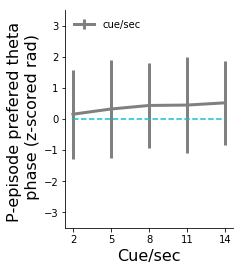

In [947]:
mmm = np.median(stats.zscore(pepi_maxs.T,0),axis=1)
sss = stats.sem(stats.zscore(pepi_maxs.T,0),axis=1)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)
fig.set_facecolor('white')

mmm = np.median(pepi_maxs,axis=0)
# sss = stats.sem(pepi_maxs,axis=0)
sss = statsmodels.robust.scale.mad(pepi_maxs,axis=0 )

plt.errorbar(  np.linspace(2,14,mmm.size), mmm, yerr=sss, label='cue/sec', linewidth=3,color=plo['cuesec_color'] )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.legend( frameon=False, loc='upper left')
plt.xlabel('Cue/sec', fontsize=16)
plt.ylabel('P-episode prefered theta \n phase (z-scored rad)', fontsize=16)
plt.xticks(  np.linspace(2,14,mmm.size).astype(int) );

plt.hlines(0,2,14, linestyle='--', color='C9')

plt.ylim( -3.5,3.5 )

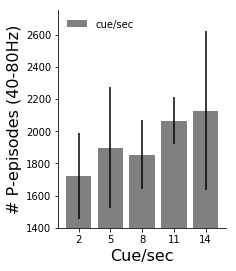

In [953]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(3)
# sns.set(font_scale=1.2, style='white')

mmm = np.median(log_p_episodes.groupby(['cuesec_w','sub']).median()['p_epi_counts'].unstack().T.values,axis=0)
# sss = stats.sem(log_p_episodes.groupby(['cuesec_w','sub']).median()['p_epi_counts'].unstack().T.values,axis=0)
sss = statsmodels.robust.scale.mad(log_p_episodes.groupby(['cuesec_w','sub']).median()['p_epi_counts'].unstack().T.values)


# plt.bar(  np.linspace(2,14,mmm.size), mmm, yerr=sss, label='cue/sec', linewidth=3, color=plo['cuesec_color'] )
plt.bar(  np.arange(5), mmm, yerr=sss, label='cue/sec', linewidth=3, color=plo['cuesec_color'] )
plt.ylim(1400)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.sca(ax)
plt.legend( frameon=False, loc='upper left')
plt.xlabel('Cue/sec', fontsize=16)
plt.ylabel('# P-episodes (' +str(low_amp_freq)+'-'+str(high_amp_freq)+'Hz)'     , fontsize=16)
# plt.xticks(range(3), ['Low','Med','High']);
# plt.xticks(np.arange(mmm.size), np.linspace(2,14,mmm.size).astype(int) );
plt.xticks(  range(5), np.linspace(2,14,mmm.size).astype(int) );
# plt.ylim(38.7,39.2)

In [955]:
mmm = log_p_episodes.groupby(['cuesec_w','sub']).median()['p_epi_counts'].unstack().T
mmm_np = mmm.to_numpy()
print( stats.friedmanchisquare(  *[mmm_np[ii] for ii in range(mmm_np.shape[0])] ))
cw_lm=ols('cuesec_w ~ p_epi_counts', data=log_p_episodes).fit() #Specify C for Categorical
print(sm.stats.anova_lm(cw_lm, typ=2))

FriedmanchisquareResult(statistic=9.239999999999995, pvalue=0.02626441798709072)
                  sum_sq     df         F    PR(>F)
p_epi_counts    0.027027    1.0  0.020991  0.884846
Residual      901.306306  700.0       NaN       NaN


# Correlate number of P-episodes with theta dominant frequency

sub: 0 SpearmanrResult(correlation=0.19999999999999998, pvalue=0.747060078104662)
sub: 1 SpearmanrResult(correlation=0.9999999999999999, pvalue=1.4042654220543672e-24)
sub: 3 SpearmanrResult(correlation=0.6, pvalue=0.28475697986529375)
sub: 4 SpearmanrResult(correlation=-0.8999999999999998, pvalue=0.03738607346849874)


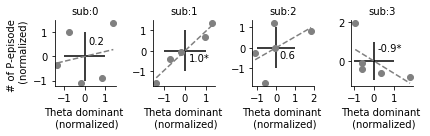

In [1440]:
# subs_psd_np       =  subs_psd.to_numpy()    # sub:0   csw:6 peaks:7
# log_p_episodes_np =  log_p_episodes.to_numpy()    # sub:0  csw:4  pepi:5


fig , ax = plt.subplots(1,4)
fig.set_figheight(2)
fig.set_figwidth(6)
fig.set_facecolor('white')

peak_pepi_all = []
pp = 0
for sub in np.unique(subs_psd_np[:,0]):    
    
    peak_pepi_sub = []
    for csw in np.unique(subs_psd_np[:,6]):
#     for csw in (np.unique(subs_psd_np[:,5])/3.9).astype(int):
        
        ccssww = (subs_psd_np[:,5]/3.9).astype(int)
        
#         idx = np.where(  np.logical_and(subs_psd_np[:,0]==sub,ccssww==csw)   )[0]
        idx = np.where(  np.logical_and(subs_psd_np[:,0]==sub,subs_psd_np[:,6]==csw)   )[0]
        peak_pepi_sub.append( [np.mean(subs_psd_np[idx,7])  ,  np.mean(log_p_episodes_np[idx,5])] )


    peak_pepi_sub = np.array(peak_pepi_sub)
    
    peak_pepi_sub = (peak_pepi_sub-np.mean(peak_pepi_sub,axis=0))/np.std(peak_pepi_sub,axis=0)


    peak_pepi_all.append(peak_pepi_sub)
       
    z  = np.polyfit(peak_pepi_sub[:,0],peak_pepi_sub[:,1],1)
    p  = np.poly1d(z)
    xp = np.linspace(peak_pepi_sub[:,0].min(),peak_pepi_sub[:,0].max(),10)
        
#     plt.sca(ax[int(pp%2),int(pp/2)])
    plt.sca(ax[pp])
    plt.plot(  peak_pepi_sub[:,0],peak_pepi_sub[:,1]  , 'o', color='grey' )
    plt.plot(xp, p(xp), linestyle='--', color='grey')
    
#     plt.hlines(0,peak_pepi_sub[:,0].min(),peak_pepi_sub[:,0].max() ,'grey')
#     plt.vlines(0,peak_pepi_sub[:,1].min(),peak_pepi_sub[:,1].max() ,'grey')
    plt.hlines(0,-1,1,'k')
    plt.vlines(0,-1,1,'k')
    
    corr_val = stats.spearmanr(  peak_pepi_sub[:,0],peak_pepi_sub[:,1] )         

    print( 'sub:',sub, corr_val )
    
    tx = 0.2
    ty = [ 0.5,-0.5,-0.5,0.5]
    ts = str(np.round(corr_val[0],2))
    if corr_val[1]<0.1: ts+='*'
    plt.text( tx,ty[pp], ts )
    plt.title('sub:'+str(pp),fontsize=10)

    
#     ax[int(pp%2),int(pp/2)].spines['right'].set_visible(False)
#     ax[int(pp%2),int(pp/2)].spines['top'].set_visible(False)
    ax[pp].spines['right'].set_visible(False)
    ax[pp].spines['top'].set_visible(False)
    
    plt.xlabel('Theta dominant \n (normalized)')
    if pp ==0: plt.ylabel('# of P-episode \n (normalized)')
        
    pp+=1
        
peak_pepi_all = np.concatenate(np.array(peak_pepi_all))
plt.tight_layout()
plt.savefig('Figures/individual_subjs_theta_and_p_episodes_correlation.pdf')

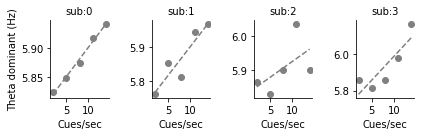

In [1439]:
# subs_psd_np       =  subs_psd.to_numpy()    # sub:0   csw:6 peaks:7
# log_p_episodes_np =  log_p_episodes.to_numpy()    # sub:0  csw:4  pepi:5


fig , ax = plt.subplots(1,4)
fig.set_figheight(2)
fig.set_figwidth(6)
fig.set_facecolor('white')


pp = 0
for sub in np.unique(subs_psd_np[:,0]):    
    
    peak_pepi_sub = []
    for csw in np.sort(np.unique(subs_psd_np[:,6])):
        
        idx = np.where(  np.logical_and(subs_psd_np[:,0]==sub,subs_psd_np[:,6]==csw)   )[0]
        peak_pepi_sub.append( np.mean(subs_psd_np[idx,7]) )


    peak_pepi_sub = np.array(peak_pepi_sub)
    
    xxxx = np.linspace(2,14,np.unique(subs_psd_np[:,6]).size).astype(int)
    
    
    z  = np.polyfit(xxxx,peak_pepi_sub,1)
    p  = np.poly1d(z)
    xp = np.linspace(xxxx.min(),xxxx.max(),10)
            
    plt.sca(ax[pp])
    plt.title('sub:'+str(pp),fontsize=10)
    plt.plot(  xxxx,peak_pepi_sub  , 'o',color='grey' )
    plt.plot(xp, p(xp), color='grey',linestyle='--')
    
    corr_val = stats.spearmanr(  xxxx,peak_pepi_sub )    
#     plt.title( str(np.round(corr_val[0],3)) +' _ '+ str(np.round(corr_val[1],3)), y=0.9 )

    plt.xlabel('Cues/sec')
    if pp ==0:plt.ylabel('Theta dominant (Hz)')
    
    ax[pp].spines['right'].set_visible(False)
    ax[pp].spines['top'].set_visible(False)
        
    pp+=1
    
    
plt.tight_layout()
plt.savefig('Figures/individual_subjs_theta_dominant.pdf')

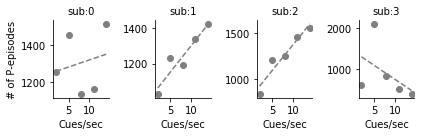

In [1438]:
# subs_psd_np       =  subs_psd.to_numpy()    # sub:0   csw:6 peaks:7
# log_p_episodes_np =  log_p_episodes.to_numpy()    # sub:0  csw:4  pepi:5


fig , ax = plt.subplots(1,4)
fig.set_figheight(2)
fig.set_figwidth(6)
fig.set_facecolor('white')


pp = 0
for sub in np.unique(subs_psd_np[:,0]):    
    
    peak_pepi_sub = []
    for csw in np.sort(np.unique(subs_psd_np[:,6])):
        
        idx = np.where(  np.logical_and(subs_psd_np[:,0]==sub,subs_psd_np[:,6]==csw)   )[0]
        peak_pepi_sub.append( np.mean(log_p_episodes_np[idx,5]) )


    peak_pepi_sub = np.array(peak_pepi_sub)
    
    xxxx = np.linspace(2,14,np.unique(subs_psd_np[:,6]).size).astype(int)
    
    
    z  = np.polyfit(xxxx,peak_pepi_sub,1)
    p  = np.poly1d(z)
    xp = np.linspace(xxxx.min(),xxxx.max(),10)
            
    plt.sca(ax[pp])
    plt.title('sub:'+str(pp),fontsize=10)
    plt.plot(  xxxx,peak_pepi_sub  , 'o',color='grey' )
    plt.plot(xp, p(xp), color='grey',linestyle='--')
    
    corr_val = stats.spearmanr(  xxxx,peak_pepi_sub )    
#     plt.title( str(np.round(corr_val[0],3)) +' _ '+ str(np.round(corr_val[1],3)), y=0.9 )

    plt.xlabel('Cues/sec')
    if pp ==0:plt.ylabel('# of P-episodes')
    
    ax[pp].spines['right'].set_visible(False)
    ax[pp].spines['top'].set_visible(False)
        
    pp+=1
    
    
plt.tight_layout()    
plt.savefig('Figures/individual_subjs_p_episodes.pdf')

SpearmanrResult(correlation=-0.04661654135338346, pvalue=0.8452698052894374)


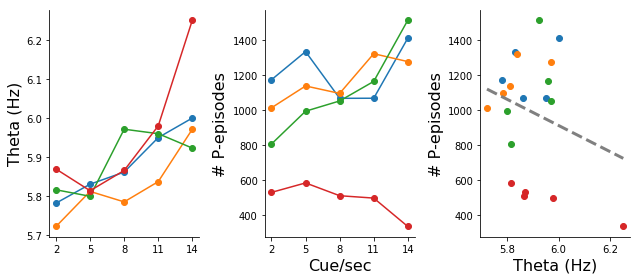

In [1122]:
mmm_epi = log_p_episodes.groupby(['cuesec_w','sub']).median()['p_epi_counts'].unstack().to_numpy()#[:,:-1]
mmm_dom = subs_psd.groupby(['csw','sub']).median()['peakkss'].unstack().to_numpy()#[:,:-1]



## Fit
z  = np.polyfit(mmm_dom.flatten(),mmm_epi.flatten(),1)
p  = np.poly1d(z)
xp = np.linspace(mmm_dom.min(),mmm_dom.max(),10)


fig , ax = plt.subplots(1,3)
fig.set_figheight(4)
fig.set_figwidth(9)
fig.set_facecolor('white')


for pp in range(3):
    plt.sca(ax[pp])
    if pp == 0: 
        plt.plot( mmm_dom , '-o')        
        plt.ylabel('Theta (Hz)', fontsize=16)
        plt.xticks( range(5), np.linspace(2,14,mmm_epi[:,0].size).astype(int) );

    if pp == 1: 
        plt.plot( mmm_epi , '-o')
        plt.ylabel('# P-episodes', fontsize=16)        
        plt.xlabel('Cue/sec', fontsize=16)        
        plt.xticks( range(5), np.linspace(2,14,mmm_epi[:,0].size).astype(int) );

        
    if pp == 2: 
        plt.plot( mmm_dom ,mmm_epi, 'o'); plt.plot(xp, p(xp), '--',color='grey',linewidth=3)
        plt.ylabel('# P-episodes', fontsize=16)
        plt.xlabel('Theta (Hz)', fontsize=16)
        
    ax[pp].spines['right'].set_visible(False)
    ax[pp].spines['top'].set_visible(False)
plt.tight_layout()
print( stats.spearmanr(mmm_dom.flatten() ,mmm_epi.flatten()) )

SpearmanrResult(correlation=-0.006015037593984962, pvalue=0.9799209119891911)


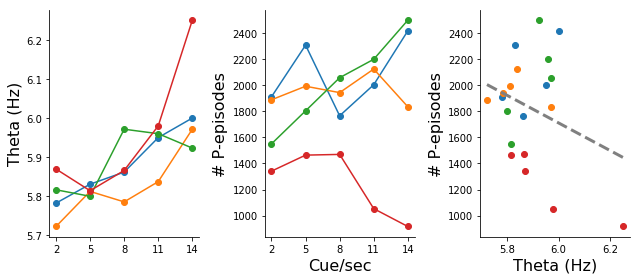

In [616]:
mmm_epi = log_p_episodes.groupby(['cuesec_w','sub']).median()['p_epi_counts'].unstack().to_numpy()#[:,:-1]
mmm_dom = subs_psd.groupby(['csw','sub']).median()['peakkss'].unstack().to_numpy()#[:,:-1]



## Fit
z  = np.polyfit(mmm_dom.flatten(),mmm_epi.flatten(),1)
p  = np.poly1d(z)
xp = np.linspace(mmm_dom.min(),mmm_dom.max(),10)


fig , ax = plt.subplots(1,3)
fig.set_figheight(4)
fig.set_figwidth(9)
fig.set_facecolor('white')


for pp in range(3):
    plt.sca(ax[pp])
    if pp == 0: 
        plt.plot( mmm_dom , '-o')        
        plt.ylabel('Theta (Hz)', fontsize=16)
        plt.xticks( range(5), np.linspace(2,14,mmm_epi[:,0].size).astype(int) );

    if pp == 1: 
        plt.plot( mmm_epi , '-o')
        plt.ylabel('# P-episodes', fontsize=16)        
        plt.xlabel('Cue/sec', fontsize=16)        
        plt.xticks( range(5), np.linspace(2,14,mmm_epi[:,0].size).astype(int) );

        
    if pp == 2: 
        plt.plot( mmm_dom ,mmm_epi, 'o'); plt.plot(xp, p(xp), '--',color='grey',linewidth=3)
        plt.ylabel('# P-episodes', fontsize=16)
        plt.xlabel('Theta (Hz)', fontsize=16)
        
    ax[pp].spines['right'].set_visible(False)
    ax[pp].spines['top'].set_visible(False)
plt.tight_layout()
print( stats.spearmanr(mmm_dom.flatten() ,mmm_epi.flatten()) )

SpearmanrResult(correlation=0.49999999999999994, pvalue=0.39100221895577053)
SpearmanrResult(correlation=0.0, pvalue=1.0)
SpearmanrResult(correlation=0.49999999999999994, pvalue=0.39100221895577053)
SpearmanrResult(correlation=-0.8999999999999998, pvalue=0.03738607346849874)


Text(0, 0.5, '# P-episodes')

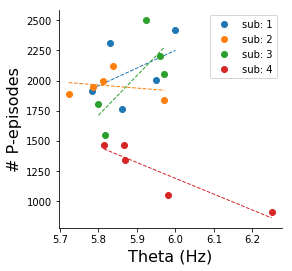

In [592]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_figheight(4)
fig.set_figwidth(4)
fig.set_facecolor('white')



for subn in range(4):
    this_sub_mmm_epi = mmm_epi[:,subn]
    this_sub_mmm_dom = mmm_dom[:,subn]

    ## Fit
    z  = np.polyfit(this_sub_mmm_dom,this_sub_mmm_epi,1)
    p  = np.poly1d(z)
    xp = np.linspace(this_sub_mmm_dom.min(),this_sub_mmm_dom.max(),10)

    plt.plot(xp, p(xp), '--',color='C'+str(subn),linewidth=1)
    plt.plot(this_sub_mmm_dom,this_sub_mmm_epi,'o', color='C'+str(subn), label='sub: '+str(subn+1) )
    print( stats.spearmanr(this_sub_mmm_dom, this_sub_mmm_epi) )
    
plt.legend()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.xlabel('Theta (Hz)', fontsize=16)
plt.ylabel('# P-episodes', fontsize=16)


# Gamma amplitude distribution along theta cycle

In [251]:
def compute_gamma_in_theta_cycle_preference():
    '''
    Compute gamma at each theta cycle quadrant
    '''

    ll_f_theta, hh_f_theta = 2,8
    ll_f_gamma, hh_f_gamma = 40,80

    
    ## Trial type
    tmp_density = np.tile( np.repeat( np.arange(3), 3 ),3)
    tmp_speed = np.tile( np.arange(3), 9 )
    tmp_dur = [ 18.1, 13.5, 11]
    tmp_dd = [50,100,150]



    for hcycle in range(4):


        amp_in_cycle = []    
        for ii in ttl_info_dict:

            filename = 'data/sub_'+str(ttl_info_dict[ii]['subject'])+'_session_'+str(ttl_info_dict[ii]['session'])+'_raw.fif'        
            raw = mne.io.read_raw_fif(filename, preload=True, verbose=False)
            trials = ttl_info_dict[ii]['markers']

            trial_begin           = 0
            trial_end             = int(raw.info['sfreq']*3)


            if trials.size == 27:

                print('Sub: ' , ttl_info_dict[ii]['subject'] )
                for cc in range(len(ttl_info_dict[ii]['hpc_channels_idx'])):


                    ch_indx = ttl_info_dict[ii]['hpc_channels_idx'][cc]
                    ch_name = ttl_info_dict[ii]['hpc_channels_name'][cc]


                    print('Channel: ', ch_indx, ch_name )

                    raw_copy = raw.copy().pick_channels([ch_name])
                    raw_copy.notch_filter([50.,100.,150.,200.],notch_widths=.1,verbose=False)

                    tmp_lfp = raw_copy.get_data()[0]


                    raw_out_theta = hilbert_transform_get_component(tmp_lfp, raw.info['sfreq'], ll_f_theta, hh_f_theta, 'phase')
                    raw_out_gama  = hilbert_transform_get_component(tmp_lfp, raw.info['sfreq'], ll_f_gamma, hh_f_gamma, 'amplitude')

                    for trial in range(len(trials)):


                        
                            if hcycle == 0:
                                idx = np.where( np.logical_and( raw_out_theta[trials[trial]:trials[trial]+trial_end]  > -np.pi ,
                                                raw_out_theta[trials[trial]:trials[trial]+trial_end]  < (-np.pi/2) ) )[0]

                            if hcycle == 1:
                                idx = np.where( np.logical_and( raw_out_theta[trials[trial]:trials[trial]+trial_end]  > (-np.pi/2) ,
                                            raw_out_theta[trials[trial]:trials[trial]+trial_end]  < 0 ) )[0]

        
                            if hcycle == 2:
                                idx = np.where( np.logical_and( raw_out_theta[trials[trial]:trials[trial]+trial_end]  > 0 ,
                                            raw_out_theta[trials[trial]:trials[trial]+trial_end]  < np.pi/2 ) )[0]
    
                            if hcycle == 3:
                                idx = np.where( np.logical_and( raw_out_theta[trials[trial]:trials[trial]+trial_end]  > np.pi/2 ,
                                            raw_out_theta[trials[trial]:trials[trial]+trial_end]  < np.pi ) )[0]


                            mean_amp_in_cycle = np.mean(raw_out_gama[idx])                    
                            cs = tmp_dd[tmp_density[trial]]/tmp_dur[tmp_speed[trial]]
                            csw = np.argmin(np.abs(cs-np.linspace(2,14,5)))
                            amp_in_cycle.append( [ttl_info_dict[ii]['subject'], tmp_density[trial], tmp_speed[trial], cs, csw, mean_amp_in_cycle] )



        amp_in_cycle = pd.DataFrame(amp_in_cycle, columns=['sub','density','speed','cuesec','cuesec_w','mean_amp_in_cycle'] )

        if hcycle == 0: amp_in_cycle_0 = amp_in_cycle#.to_numpy()
        if hcycle == 1: amp_in_cycle_1 = amp_in_cycle#.to_numpy()
        if hcycle == 2: amp_in_cycle_2 = amp_in_cycle#.to_numpy()
        if hcycle == 3: amp_in_cycle_3 = amp_in_cycle#.to_numpy()
            
            
            
    return amp_in_cycle_0,amp_in_cycle_1,amp_in_cycle_2,amp_in_cycle_3
            

In [252]:
amp_in_cycle_0,amp_in_cycle_1,amp_in_cycle_2,amp_in_cycle_3 = compute_gamma_in_theta_cycle_preference()

Sub:  0
Channel:  47 B1
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Channel:  48 B2
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Channel:  55 C1
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Channel:  56 C2
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Creating RawArray 

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.
Sub:  0
Channel:  47 B1
Creating RawArray with float64 data, n_channels=1, n_times=210001
    Range : 0 ... 210000 =      0.000 ...   420.000 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=210001
    Range : 0 ... 210000 =      0.000 ...   420.000 secs
Ready.
Channel:  48 B2
Creating RawArray with float64 data, n_channels=1, n_times=210001
    Range : 0 ... 210000 =      0.000 ...   420.000 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=210001
    Range : 0 ... 210000 =      0.000 ...   420.000 secs
Ready.
Channel:  55 C1
Creating RawArray with float64 data, n_channels=1, n_times=210001
    Range : 0 ... 210000 =      0.000 ...   420.000 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=210001
    Range : 0 ... 210000 =      0.000 ...   420.000 secs
Ready.
Channel:  56 C2
Creating Ra

Ready.
Channel:  56 C2
Creating RawArray with float64 data, n_channels=1, n_times=210001
    Range : 0 ... 210000 =      0.000 ...   420.000 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=210001
    Range : 0 ... 210000 =      0.000 ...   420.000 secs
Ready.
Sub:  0
Channel:  47 B1
Creating RawArray with float64 data, n_channels=1, n_times=200001
    Range : 0 ... 200000 =      0.000 ...   400.000 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=200001
    Range : 0 ... 200000 =      0.000 ...   400.000 secs
Ready.
Channel:  48 B2
Creating RawArray with float64 data, n_channels=1, n_times=200001
    Range : 0 ... 200000 =      0.000 ...   400.000 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=200001
    Range : 0 ... 200000 =      0.000 ...   400.000 secs
Ready.
Channel:  55 C1
Creating RawArray with float64 data, n_channels=1, n_times=200001
    Range : 0 ... 200000 =      0.000 ...   400.000 secs
Ready.
Creating Ra

Ready.
Creating RawArray with float64 data, n_channels=1, n_times=200001
    Range : 0 ... 200000 =      0.000 ...   400.000 secs
Ready.
Channel:  56 C2
Creating RawArray with float64 data, n_channels=1, n_times=200001
    Range : 0 ... 200000 =      0.000 ...   400.000 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=200001
    Range : 0 ... 200000 =      0.000 ...   400.000 secs
Ready.
Sub:  1
Channel:  19 B'1
Creating RawArray with float64 data, n_channels=1, n_times=215001
    Range : 0 ... 215000 =      0.000 ...   430.000 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=215001
    Range : 0 ... 215000 =      0.000 ...   430.000 secs
Ready.
Channel:  20 B'2
Creating RawArray with float64 data, n_channels=1, n_times=215001
    Range : 0 ... 215000 =      0.000 ...   430.000 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=215001
    Range : 0 ... 215000 =      0.000 ...   430.000 secs
Ready.
Channel:  29 C'1
Creating

In [253]:
cycle_quadrant = []
tmp = np.median(amp_in_cycle_0.groupby(['cuesec_w','sub']).median()['mean_amp_in_cycle'].unstack().to_numpy(), axis=1) 
cycle_quadrant.append(tmp)
tmp = np.median(amp_in_cycle_1.groupby(['cuesec_w','sub']).median()['mean_amp_in_cycle'].unstack().to_numpy(), axis=1) 
cycle_quadrant.append(tmp)
tmp = np.median(amp_in_cycle_2.groupby(['cuesec_w','sub']).median()['mean_amp_in_cycle'].unstack().to_numpy(), axis=1) 
cycle_quadrant.append(tmp)
tmp = np.median(amp_in_cycle_3.groupby(['cuesec_w','sub']).median()['mean_amp_in_cycle'].unstack().to_numpy(), axis=1) 
cycle_quadrant.append(tmp)

cycle_quadrant = np.array(cycle_quadrant)



7.049134183034766e-05 9.56328512984328e-05


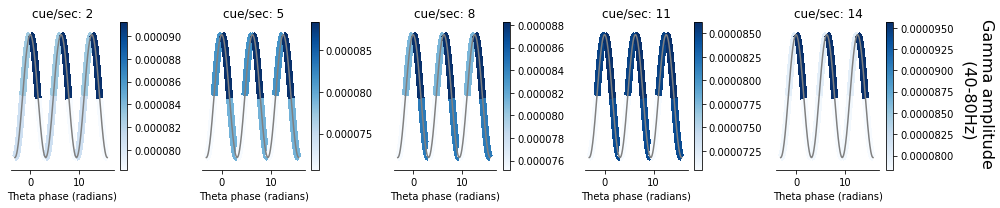

In [859]:
fig = plt.figure()
fig.set_figheight(3)
fig.set_figwidth(14)
fig.set_facecolor('white')

mmin = 10
mmax = 0

for csw_cond in range(5):

    this_cq_normalized = np.copy(cycle_quadrant[:,csw_cond])
#     this_cq_normalized -= this_cq_normalized.min()
#     this_cq_normalized = this_cq_normalized / this_cq_normalized.max()

    sizee = 100
    x = np.linspace(-np.pi,np.pi,sizee)    
    y = np.cos(x)
    t = np.repeat(this_cq_normalized, sizee/4)

    x = np.concatenate([x,x+x.max()*2,x+x.max()*4])
    y = np.tile(y,3)
    t = np.tile(t,3)


    points = np.array([x,y]).transpose().reshape(-1,1,2)
    segs = np.concatenate([points[:-1],points[1:]],axis=1)    
    lc = LineCollection(segs, cmap='Blues', linewidth=6, antialiaseds=False) # make the collection of segments
    lc.set_array(t) # color the segments by our parameter
    
    if t.max()>mmax: mmax=t.max()
    if t.min()<mmin: mmin=t.min()

    
    ax = fig.add_subplot(1,5,csw_cond+1)
    plt.plot(x,y, color='Grey')
    plt.gca().add_collection(lc) # add the collection to the plot


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.yticks([])
    ax.spines['left'].set_visible(False)

        
    plt.xlim(-4,17)
    plt.ylim(-1.2,1.2)
    plt.xlabel('Theta phase (radians)')
    plt.title('cue/sec: '+  str(int(np.linspace(2,14,5)[csw_cond])) )
    cbar = fig.colorbar(lc)
#     cbar.set_clim(7.049134183034766e-05,9.56328512984328e-05)
cbar.set_label('Gamma amplitude \n (40-80Hz)', rotation=270, labelpad=40, fontsize=16)

print(mmin,mmax)


plt.tight_layout()
plt.savefig('Figures/Gamma_amplitude_in_theta_phase_cuesec.pdf')


<Figure size 1000x1000 with 0 Axes>

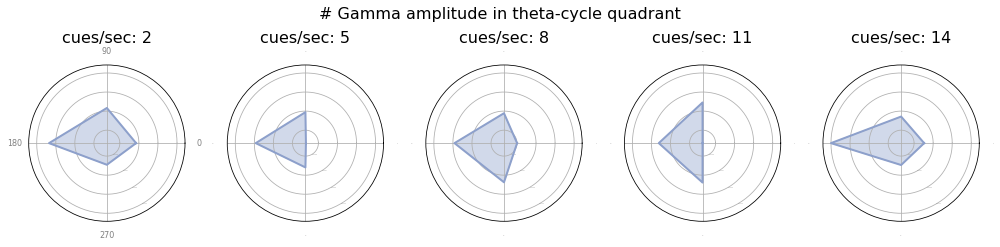

In [868]:
# cycle_quadrant_p_epi

from math import pi
 
# Set data
df = pd.DataFrame({
'group': ['2','5','8','11','14'],
'0': cycle_quadrant[0,:],
'90': cycle_quadrant[1,:],
'180': cycle_quadrant[2,:],
'270': cycle_quadrant[3,:],
})
 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider( row, title, color):
    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
#     plt.figure(figsize=(18,4))
    ax = plt.subplot(1,5,row+1, polar=True )

    # If you want the first axis to be on top:
#     ax.set_theta_offset(pi / 2)
#     ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(300)
    
    plt.yticks(  np.linspace(0,cycle_quadrant.max(),15), color='grey', fontsize=0 )
    plt.ylim(cycle_quadrant.min(),cycle_quadrant.max()*1.03)

    
    
    plt.xticks()
    if row !=0:
        plt.xticks( fontsize=0 )
        plt.yticks( fontsize=0 )
    
    
    # Ind1
    values=df.loc[row].drop('group').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)


    # Add a title
    plt.title(title, size=16, color='k', y=1.1)

# ------- PART 2: Apply to all individuals
# initialize the figure
my_dpi=96
plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)

# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(df.index))

# Loop to plot
fig = plt.figure(figsize=(14,3))
fig.set_facecolor('white')
plt.suptitle('# Gamma amplitude in theta-cycle quadrant', fontsize=16, y=1.1)
for row in range(0, len(df.index)):
    make_spider( row=row, title='cues/sec: '+df['group'][row], color=my_palette(1))   #color=my_palette(row))

    
    
plt.tight_layout()
plt.savefig('Figures/Gamma_amplitude_in_theta_phase_cuesec_spider.pdf')


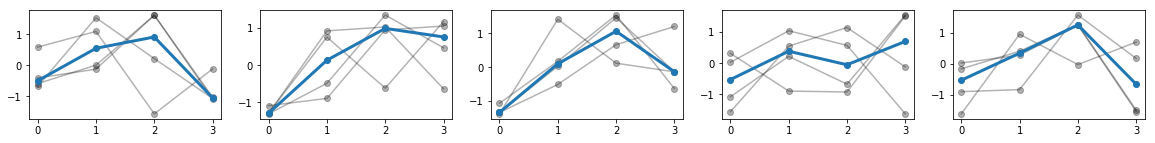

<Figure size 432x288 with 0 Axes>

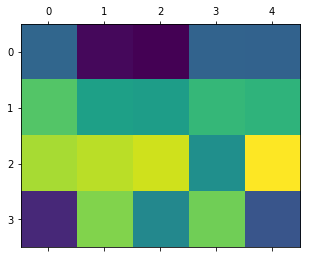

In [1378]:
csw_all = [] 

plt.figure(figsize=(20,2))
for csw_cond in range(5):
    plt.subplot(1,5,csw_cond+1)
    
    csw_tmp = []
    
    for subb in range(4):
        tmptmp = []
        tmptmp.append( amp_in_cycle_0.groupby(['cuesec_w','sub']).median()['mean_amp_in_cycle'].unstack().to_numpy()[:,subb] )
        tmptmp.append( amp_in_cycle_1.groupby(['cuesec_w','sub']).median()['mean_amp_in_cycle'].unstack().to_numpy()[:,subb] )
        tmptmp.append( amp_in_cycle_2.groupby(['cuesec_w','sub']).median()['mean_amp_in_cycle'].unstack().to_numpy()[:,subb] )
        tmptmp.append( amp_in_cycle_3.groupby(['cuesec_w','sub']).median()['mean_amp_in_cycle'].unstack().to_numpy()[:,subb] )
        tmptmp = np.array(tmptmp)
        plt.plot(stats.zscore(tmptmp[:,csw_cond]), '-ok',  alpha=0.3)
        csw_tmp.append(  stats.zscore(tmptmp[:,csw_cond]) )
        
    plt.plot(np.median(csw_tmp,axis=0), '-o', linewidth=3)
    
    csw_all.append(  np.median(csw_tmp,axis=0)  )

    
plt.figure()
plt.matshow(np.array(csw_all).T)


# Supplementary material

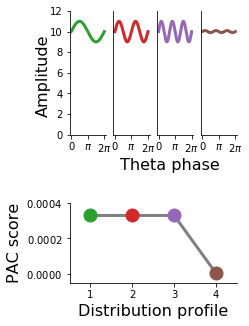

In [1272]:
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

cccc = ['C2','C3','C4','C5']
log_fake_kb = []
fig = plt.figure(figsize=(3,5))
fig.set_facecolor('white')
for ii in range(1,5):

    x = np.linspace(0,2*np.pi,1000)
    y = np.sin(x*ii) +  10    
    if ii==4: y = np.sin(x*(ii-1))/10 +  10

    pad = np.copy(y)
    pad_2 = np.hstack((pad , pad))
    num_bins = pad_2.size
    n_pevents = float(np.sum(pad_2))
    ppp = -1 * np.sum((pad_2/n_pevents) * np.log((pad_2/n_pevents)))
    K_L = (np.log(num_bins) - ppp) / np.log(num_bins)

    ax = plt.subplot2grid((2,4),(int((ii-1)/4) , int((ii-1)%4)), rowspan=1, colspan=1)
    if ii != 1: plt.yticks([])
    if ii not in [3,4]: plt.xticks([])
    plt.xticks([0,np.pi,2*np.pi],  [ '0',r"$\pi$",'2'+r"$\pi$"]  )            
    plt.plot(x, y, color=cccc[ii-1], linewidth=3)
    plt.ylim(0,12)    
    log_fake_kb.append(K_L)
#     plt.text(1,4,str(ii),color=cccc[ii-1], fontsize=50)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.text(-0.03, 0.7, 'Amplitude',fontsize=16, va='center', rotation='vertical')
fig.text(0.36, 0.45, 'Theta phase',fontsize=16, va='center', rotation='horizontal')



ii += 1
ax = plt.subplot2grid((3,2),(2,0), rowspan=1, colspan=2)
plt.plot(log_fake_kb,'-o', color='Grey', linewidth=3)
for jj in range(len(log_fake_kb)):
    plt.plot( jj, log_fake_kb[jj],'o', color=cccc[jj], markersize=13  )
#     plt.bar(jj,log_fake_kb[jj], color=cccc[jj])
plt.ylabel('PAC score',fontsize=16)
plt.xlabel('Distribution profile',fontsize=16)
plt.xlim(-.5,3.5)
ax.set_ylim(-.005e-2,.04e-2)
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.xticks(range(4), np.arange(4)+1 )
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [1085]:
ii = 0
filename = 'data/sub_'+str(ttl_info_dict[ii]['subject'])+'_session_'+str(ttl_info_dict[ii]['session'])+'_raw.fif'

raw = mne.io.read_raw_fif(filename, preload=True, verbose=False)

sizee = int(raw.info['sfreq']*2.5)
sss = ttl_info_dict[ii]['markers'][1]
eee = sss+sizee



cc = 1
ch_indx = ttl_info_dict[ii]['hpc_channels_idx'][cc]
ch_name = ttl_info_dict[ii]['hpc_channels_name'][cc]

raw_copy = raw.copy().pick_channels([ch_name])
raw_copy.notch_filter([50.,100.,150.,200.],notch_widths=2,verbose=False)

tmp_lfp = raw_copy.get_data()[0]
tmp_lfp -= np.mean(tmp_lfp)

raw_out_theta = hilbert_transform_get_component(tmp_lfp, raw.info['sfreq'], 2, 8, 'phase')


x = np.linspace(  0 , sizee/raw.info['sfreq'], sizee      )
y = tmp_lfp[sss:eee]
t = raw_out_theta[sss:eee]

Creating RawArray with float64 data, n_channels=1, n_times=208001
    Range : 0 ... 208000 =      0.000 ...   416.000 secs
Ready.


(1250, 1, 2)
(1249, 2, 2)


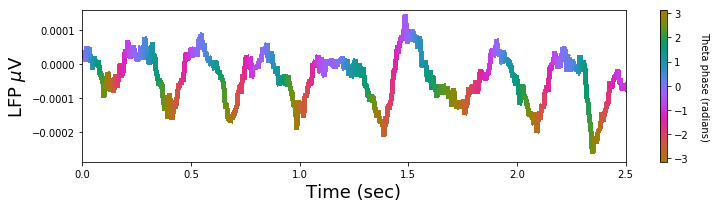

In [1087]:
# set up a list of (x,y) points
points = np.array([x,y]).transpose().reshape(-1,1,2)
print( points.shape)  # Out: (len(x),1,2)

# set up a list of segments
segs = np.concatenate([points[:-1],points[1:]],axis=1)
print( segs.shape)  # Out: ( len(x)-1, 2, 2 )
                  # see what we've done here -- we've mapped our (x,y)
                  # points to an array of segment start/end coordinates.
                  # segs[i,0,:] == segs[i-1,1,:]

# make the collection of segments
lc = LineCollection(segs, cmap=cmocean.cm.phase, linewidth=4, antialiaseds=False)
lc.set_array(t) # color the segments by our parameter

# plot the collection
fig = plt.figure(figsize=(20,3))
ax = fig.add_subplot(121)

plt.gca().add_collection(lc) # add the collection to the plot
plt.xlim(x.min(), x.max()) # line collections don't auto-scale the plot
plt.ylim(y.min()*1.1, y.max()*1.1)
# plt.ylim(-0.006439802129239476, -0.005449797328503205)

cbar = fig.colorbar(lc)
cbar.set_label('Theta phase (radians)', rotation=270, labelpad=20)

fig.set_facecolor('xkcd:white')


plt.ylabel(r'LFP $\mu$V', fontsize=18)
plt.xlabel('Time (sec)', fontsize=18)


plt.tight_layout()
plt.savefig('Figures/theta_phase_in_lfp_example.pdf')
